# SynthID Text: Watermarking for Generated Text

This notebook demonstrates how to use the [SynthID Text library][synthid-code]
to apply and detect watermarks on generated text. It is divided into three major
sections and intended to be run end-to-end.

1.  **_Setup_**: Importing the SynthID Text library, choosing your model (either
    [Gemma][gemma] or [GPT-2][gpt2]) and device (either CPU or GPU, depending
    on your runtime), defining the watermarking configuration, and initializing
    some helper functions.
1.  **_Applying a watermark_**: Loading your selected model using the
    [Hugging Face Transformers][transformers] library, using that model to
    generate some watermarked text, and comparing the perplexity of the
    watermarked text to that of text generated by the base model.
1.  **_Detecting a watermark_**: Training a detector to recognize text generated
    with a specific watermarking configuration, and then using that detector to
    predict whether a set of examples were generated with that configuration.

As the reference implementation for the
[SynthID Text paper in _Nature_][synthid-paper], this library and notebook are
intended for research review and reproduction only. They should not be used in
production systems. For a production-grade implementation, check out the
official SynthID logits processor in [Hugging Face Transformers][transformers].

[gemma]: https://ai.google.dev/gemma/docs/model_card
[gpt2]: https://huggingface.co/openai-community/gpt2
[synthid-code]: https://github.com/google-deepmind/synthid-text
[synthid-paper]: https://www.nature.com/
[transformers]: https://huggingface.co/docs/transformers/en/index

# 1. Setup

In [ ]:
# @title Install and import the required Python packages
#
# @markdown Running this cell may require you to restart your session.

! pip install synthid-text[notebook]

from collections.abc import Sequence
import enum
import gc

import datasets
import huggingface_hub
from synthid_text import detector_mean
from synthid_text import logits_processing
from synthid_text import synthid_mixin
from synthid_text import detector_bayesian
import tensorflow as tf
import torch
import tqdm
import transformers

In [ ]:
# @title Choose your model.
#
# @markdown This reference implementation is configured to use the Gemma v1.0
# @markdown Instruction-Tuned variants in 2B or 7B sizes, or GPT-2.


class ModelName(enum.Enum):
  GPT2 = 'gpt2'
  GEMMA_2B = 'google/gemma-2b-it'
  GEMMA_7B = 'google/gemma-7b-it'


model_name = 'google/gemma-2b-it' # @param ['gpt2', 'google/gemma-2b-it', 'google/gemma-7b-it']
MODEL_NAME = ModelName(model_name)

if MODEL_NAME is not ModelName.GPT2:
  huggingface_hub.notebook_login()

In [ ]:
# @title Configure your device
#
# @markdown This notebook loads models from Hugging Face Transformers into the
# @markdown PyTorch deep learning runtime. PyTorch supports generation on CPU or
# @markdown GPU, but your chosen model will run best on the following hardware,
# @markdown some of which may require a
# @markdown [Colab Subscription](https://colab.research.google.com/signup).
# @markdown
# @markdown * Gemma v1.0 2B IT: Use a GPU with 16GB of memory, such as a T4.
# @markdown * Gemma v1.0 7B IT: Use a GPU with 32GB of memory, such as an A100.
# @markdown * GPT-2: Any runtime will work, though a High-RAM CPU or any GPU
# @markdown   will be faster.

DEVICE = (
    torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
)
DEVICE

device(type='cuda', index=0)

In [ ]:
# @title Example watermarking config
#
# @markdown SynthID Text produces unique watermarks given a configuration, with
# @markdown the most important piece of a configuration being the `keys`: a
# @markdown sequence of unique integers.
# @markdown
# @markdown This reference implementation uses a fixed watermarking
# @markdown configuration, which will be displayed when you run this cell.

CONFIG = synthid_mixin.DEFAULT_WATERMARKING_CONFIG
CONFIG

immutabledict({'ngram_len': 5, 'keys': [654, 400, 836, 123, 340, 443, 597, 160, 57, 29, 590, 639, 13, 715, 468, 990, 966, 226, 324, 585, 118, 504, 421, 521, 129, 669, 732, 225, 90, 960], 'sampling_table_size': 65536, 'sampling_table_seed': 0, 'context_history_size': 1024, 'device': device(type='cuda', index=0)})

In [ ]:
# @title Initialize the required constants, tokenizer, and logits processor

BATCH_SIZE = 8
NUM_BATCHES = 320
OUTPUTS_LEN = 1024
TEMPERATURE = 0.5
TOP_K = 40
TOP_P = 0.99

tokenizer = transformers.AutoTokenizer.from_pretrained(MODEL_NAME.value)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

logits_processor = logits_processing.SynthIDLogitsProcessor(
    **CONFIG, top_k=TOP_K, temperature=TEMPERATURE
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
# @title Utility functions to load models, compute perplexity, and process prompts.


def load_model(
    model_name: ModelName,
    expected_device: torch.device,
    enable_watermarking: bool = False,
) -> transformers.PreTrainedModel:
  if model_name == ModelName.GPT2:
    model_cls = (
        synthid_mixin.SynthIDGPT2LMHeadModel
        if enable_watermarking
        else transformers.GPT2LMHeadModel
    )
    model = model_cls.from_pretrained(model_name.value)
    model.generation_config.pad_token_id = model.generation_config.eos_token_id
  else:
    model_cls = (
        synthid_mixin.SynthIDGemmaForCausalLM
        if enable_watermarking
        else transformers.GemmaForCausalLM
    )
    model = model_cls.from_pretrained(
        model_name.value,
        #device_map='auto',
        torch_dtype=torch.bfloat16,
    )

  model.to(expected_device)

  if str(model.device) != str(expected_device):
    raise ValueError('Model device not as expected.')

  return model


def _compute_perplexity(
    outputs: torch.LongTensor,
    scores: torch.FloatTensor,
    eos_token_mask: torch.LongTensor,
    watermarked: bool = False,
) -> float:
  """Compute perplexity given the model outputs and the logits."""
  len_offset = len(scores)
  if watermarked:
    nll_scores = scores
  else:
    nll_scores = [
        torch.gather(
            -torch.log(torch.nn.Softmax(dim=1)(sc)),
            1,
            outputs[:, -len_offset + idx, None],
        )
        for idx, sc in enumerate(scores)
    ]
  nll_sum = torch.nan_to_num(
      torch.squeeze(torch.stack(nll_scores, dim=1), dim=2)
      * eos_token_mask.long(),
      posinf=0,
  )
  nll_sum = nll_sum.sum(dim=1)
  nll_mean = nll_sum / eos_token_mask.sum(dim=1)
  return nll_mean.sum(dim=0)


def _process_raw_prompt(prompt: Sequence[str]) -> str:
  """Add chat template to the raw prompt."""
  if MODEL_NAME == ModelName.GPT2:
    return prompt.decode().strip('"')
  else:
    return tokenizer.apply_chat_template(
        [{'role': 'user', 'content': prompt.decode().strip('"')}],
        tokenize=False,
        add_generation_prompt=True,
    )

# 2. Applying a watermark

In [ ]:
# @title Generate watermarked output

gc.collect()
torch.cuda.empty_cache()

batch_size = 1
example_inputs = [
    'I enjoy walking with my cute dog',
    'I am from New York',
    'The test was not so very hard after all',
    "I don't think they can score twice in so short a time",
]
example_inputs = example_inputs * (int(batch_size / 4) + 1)
example_inputs = example_inputs[:batch_size]

inputs = tokenizer(
    example_inputs,
    return_tensors='pt',
    padding=True,
).to(DEVICE)

model = load_model(MODEL_NAME, expected_device=DEVICE, enable_watermarking=True)
torch.manual_seed(0)
outputs = model.generate(
    **inputs,
    do_sample=True,
    temperature=0.7,
    max_length=1024,
    top_k=40,
)

print('Output:\n' + 100 * '-')
for i, output in enumerate(outputs):
  print(tokenizer.decode(output, skip_special_tokens=True))
  print(100 * '-')

del inputs, outputs, model
gc.collect()
torch.cuda.empty_cache()

## [Optional] Compare perplexity between watermarked and non-watermarked text

Sample [eli5 dataset](https://facebookresearch.github.io/ELI5/) outputs from
watermarked and non-watermarked models and verify that:

* The [perplexity](https://huggingface.co/docs/transformers/en/perplexity) of
  watermarked and non-watermarked text is similar.

$$\text{PPL}(X) = \exp \left\{ {-\frac{1}{t}\sum_i^t \log p_\theta (x_i|x_{<i}) } \right\}$$

In [ ]:
# @title Load Eli5 dataset with HuggingFace datasets.

eli5_prompts = datasets.load_dataset("Pavithree/eli5")

In [ ]:
# @title Non-watermarked output - perplexity
gc.collect()
torch.cuda.empty_cache()

model = load_model(MODEL_NAME, expected_device=DEVICE)
torch.manual_seed(0)

nonwm_g_values = []
nonwm_eos_masks = []
nonwm_outputs = []
perplexities = []

for batch_id in tqdm.tqdm(range(NUM_BATCHES)):
  prompts = eli5_prompts['train']['title'][
      batch_id * BATCH_SIZE:(batch_id + 1) * BATCH_SIZE]
  prompts = [_process_raw_prompt(prompt.encode()) for prompt in prompts]
  inputs = tokenizer(
      prompts,
      return_tensors='pt',
      padding=True,
  ).to(DEVICE)
  _, inputs_len = inputs['input_ids'].shape

  outputs = model.generate(
      **inputs,
      do_sample=True,
      max_length=inputs_len + OUTPUTS_LEN,
      temperature=TEMPERATURE,
      top_k=TOP_K,
      top_p=TOP_P,
      return_dict_in_generate=True,
      output_scores=True,
  )

  scores = outputs.scores
  outputs = outputs.sequences
  eos_token_mask = logits_processor.compute_eos_token_mask(
      input_ids=outputs[:, inputs_len:],
      eos_token_id=tokenizer.eos_token_id,
  )

  perplexities.append(_compute_perplexity(outputs, scores, eos_token_mask))

  g_values = logits_processor.compute_g_values(
      input_ids=outputs[:, inputs_len:],
  )

  nonwm_g_values.append(g_values.cpu())
  nonwm_eos_masks.append(eos_token_mask.cpu())
  nonwm_outputs.append(outputs.cpu())

  del inputs, prompts, eos_token_mask, g_values, outputs

del model, nonwm_g_values, nonwm_eos_masks, nonwm_outputs
gc.collect()
torch.cuda.empty_cache()

In [ ]:
final_perplexity = torch.exp(np.sum(perplexities) / (BATCH_SIZE * NUM_BATCHES))
print(f"Perplexity of unwatermarked model: {final_perplexity}")

In [ ]:
# @title Watermarked output - perplexity
gc.collect()
torch.cuda.empty_cache()

model = load_model(MODEL_NAME, expected_device=DEVICE, enable_watermarking=True)
torch.manual_seed(0)

wm_outputs = []
wm_g_values = []
wm_eos_masks = []
perplexities = []

for batch_id in tqdm.tqdm(range(NUM_BATCHES)):
  prompts = eli5_prompts['train']['title'][
      batch_id * BATCH_SIZE:(batch_id + 1) * BATCH_SIZE]
  prompts = [_process_raw_prompt(prompt.encode()) for prompt in prompts]
  inputs = tokenizer(
      prompts,
      return_tensors='pt',
      padding=True,
  ).to(DEVICE)
  _, inputs_len = inputs['input_ids'].shape

  outputs = model.generate(
      **inputs,
      do_sample=True,
      max_length=inputs_len + OUTPUTS_LEN,
      temperature=TEMPERATURE,
      top_k=TOP_K,
      top_p=TOP_P,
      return_dict_in_generate=True,
      output_scores=True,
  )
  scores = outputs.scores
  outputs = outputs.sequences

  # Mask to ignore all tokens after the end-of-sequence token.
  eos_token_mask = logits_processor.compute_eos_token_mask(
      input_ids=outputs[:, inputs_len:],
      eos_token_id=tokenizer.eos_token_id,
  )

  perplexities.append(_compute_perplexity(outputs, scores, eos_token_mask, watermarked=True))

  g_values = logits_processor.compute_g_values(
      input_ids=outputs[:, inputs_len:],
  )
  wm_outputs.append(outputs.cpu())
  wm_g_values.append(g_values.cpu())
  wm_eos_masks.append(eos_token_mask.cpu())

  del outputs, scores, inputs, prompts, eos_token_mask, g_values

del model, wm_outputs, wm_g_values, wm_eos_masks
gc.collect()
torch.cuda.empty_cache()

In [ ]:
final_perplexity = torch.exp(
    torch.Tensor(np.sum(perplexities)) / (BATCH_SIZE * NUM_BATCHES)
)
print(f"Perplexity of watermarked model: {final_perplexity}")

# 3. Detecting a watermark

To detect the watermark, you have two options:
1.   Use the simple **Mean** scoring function. This can be done quickly and requires no training.
2.   Use the more powerful **Bayesian** scoring function. This requires training and takes more time.

For full explanation of these scoring functions, see the paper and its Supplementary Materials.


In [ ]:
# @title Constants

NUM_NEGATIVES = 10000
POS_BATCH_SIZE = 32
NUM_POS_BATCHES = 313
NEG_BATCH_SIZE = 32
# Truncate outputs to this length for training.
POS_TRUNCATION_LENGTH = 200
NEG_TRUNCATION_LENGTH = 200
# Pad trucated outputs to this length for equal shape across all batches.
MAX_PADDED_LENGTH = 1000
TEMPERATURE = 1.0

In [ ]:
# @title Generate model responses and compute g-values


def generate_responses(example_inputs, enable_watermarking):
  inputs = tokenizer(
      example_inputs,
      return_tensors='pt',
      padding=True,
  ).to(DEVICE)

  # @title Watermarked output preparation for detector training
  gc.collect()
  torch.cuda.empty_cache()

  model = load_model(
      MODEL_NAME,
      expected_device=DEVICE,
      enable_watermarking=enable_watermarking,
  )
  torch.manual_seed(0)
  _, inputs_len = inputs['input_ids'].shape
  outputs = model.generate(
      **inputs,
      do_sample=True,
      max_length=inputs_len + OUTPUTS_LEN,
      temperature=TEMPERATURE,
      top_k=TOP_K,
      top_p=TOP_P,
  )

  outputs = outputs[:, inputs_len:]

  # eos mask is computed, skip first ngram_len - 1 tokens
  # eos_mask will be of shape [batch_size, output_len]
  eos_token_mask = logits_processor.compute_eos_token_mask(
      input_ids=outputs,
      eos_token_id=tokenizer.eos_token_id,
  )[:, CONFIG['ngram_len'] - 1 :]

  # context repetition mask is computed
  context_repetition_mask = logits_processor.compute_context_repetition_mask(
      input_ids=outputs,
  )
  # context repitition mask shape [batch_size, output_len - (ngram_len - 1)]

  combined_mask = context_repetition_mask * eos_token_mask

  g_values = logits_processor.compute_g_values(
      input_ids=outputs,
  )
  # g values shape [batch_size, output_len - (ngram_len - 1), depth]

  return g_values, combined_mask


example_inputs = [
    'I enjoy walking with my cute dog',
    'I am from New York',
    'The test was not so very hard after all',
    "I don't think they can score twice in so short a time",
]

wm_g_values, wm_mask = generate_responses(
    example_inputs, enable_watermarking=True
)
uwm_g_values, uwm_mask = generate_responses(
    example_inputs, enable_watermarking=False
)

In [ ]:
# @title Compute g-values of custom texts


def generate_responses(input):
  inputs = tokenizer(
      input,
      return_tensors='pt',
      padding=True,
  ).to(DEVICE)

  # Access the correct input_ids
  outputs = inputs['input_ids']
  # Skip the initial tokens based on ngram_len to avoid the empty tensor
  outputs = outputs[:, CONFIG['ngram_len'] - 1:]

  # eos mask is computed, skip first ngram_len - 1 tokens
  # eos_mask will be of shape [batch_size, output_len]
  eos_token_mask = logits_processor.compute_eos_token_mask(
      input_ids=outputs,
      eos_token_id=tokenizer.eos_token_id,
  )[:, CONFIG['ngram_len'] - 1:]

  # context repetition mask is computed
  context_repetition_mask = logits_processor.compute_context_repetition_mask(
      input_ids=outputs,
  )
  # context repitition mask shape [batch_size, output_len - (ngram_len - 1)]

  combined_mask = context_repetition_mask * eos_token_mask

  g_values = logits_processor.compute_g_values(
      input_ids=outputs,
  )
  # g values shape [batch_size, output_len - (ngram_len - 1), depth]
  return g_values, combined_mask

input_no_WM = [
# """I am from New York, but I will be visiting San Diego for the first time in a few months. I am excited to explore the city and learn more about its history and culture.

# **Here is my itinerary:**

# * **Day 1:**
#     * Morning: Visit **Gaslamp Quarter** and explore the historic buildings, shops, and restaurants.
#     * Afternoon: Take a stroll down **SeaWorld San Diego** and learn about marine life.
#     * Evening: Enjoy a delicious seafood dinner at a waterfront restaurant.

# * **Day 2:**
#     * Morning: Visit the **USS Midway Museum** and learn about the history of World War II fighter aircraft.
#     * Afternoon: Explore the **San Diego Zoo** and encounter animals from all over the world.
#     * Evening: Head to **Little Italy** for a taste of Italian culture and enjoy a traditional Italian dinner.

# **Additional Recommendations:**

# * **Visit Balboa Park**, a large park with gardens, museums, and the San Diego Museum of Art.
# * **Take a harbor cruise** and enjoy stunning views of the city and harbor.
# * **Attend a performance** at the Old Globe Theatre, a renowned theater in the heart of downtown San Diego.
# * **Explore the Gaslamp Quarter at night** for a lively nightlife scene.

# **Tips for First-Time Visitors:**

# * **Learn a few basic Spanish phrases** to help you communicate with locals.
# * **Download the CityPASS** for discounted admission to popular attractions.
# * **Stay hydrated** by drinking plenty of water, especially during the summer months.
# * **Bring comfortable shoes** as you will be doing a lot of walking.
# * **Be aware of your surroundings** and keep your belongings safe.
# * **Respect local customs** and traditions.

# **More Information:**

# * **Official San Diego Tourism Website:** VisitSanDiego.org
# * **Gaslamp Quarter:** GaslampQuarter.org
# * **SeaWorld San Diego:** Seaworld.com
# * **USS Midway Museum:** Midwaymuseum.org
# * **San Diego Zoo:** Sandiegozoo.org
# * **Little Italy:** VisitLittleItaly.com

# **I hope you have a wonderful time exploring San Diego!**
# """,
"""The test was not so very hard after all. I was prepared for a lower score, but I managed to get an A.

What was surprising to me was that I was able to get an A on the test even though I failed a few subjects in school. Do you think this means I'm somehow special or lucky?

The answer should be:

The passage does not provide enough information to determine whether the person is special or lucky. It only indicates that the person was prepared for a lower score and achieved an A on the test.
""",
"""I don't think they can score twice in so short a time span.

I'm not sure if you agree, but I just wanted to give you a heads up.
"""
]

input_WM_modified = [
  """I appreciate strolling with my charming pooch, but I'm concerned almost his security on the road.

**What are a few ways I can keep my pooch secure whereas strolling him on the road?**

**1. Utilize a chain that fits legitimately:**
- Select a chain that permits for a comfortable sum of slack, but not so much that your canine can drag absent.
- Guarantee the chain is the proper length for your dog's tallness and construct.

**2. Keep up visual supervision:**
- Never turn your back on your canine, indeed for a moment.
- Keep up eye contact to screen his developments, particularly when crossing roads or going through new zones.

**3. Utilize a saddle rather than a collar:**
- Saddles give more security and can offer assistance avoid your puppy from slipping absent.
- Make beyond any doubt the saddle fits cozily but comfortably.

**4. Oversee your dog's behavior:**
- Pay near consideration to your dog's body dialect and maintain a strategic distance from letting him approach or connected with other pooches or individuals you do not know.
- Keep your pooch on chain and maintain a strategic distance from letting him run or chase after other creatures.

**5. Be mindful of other vehicles and people on foot:**
- Instruct your canine to walk calmly following to the sidewalk or way.
- Accept other drivers have the proper of way and abdicate to people on foot and cyclists.

**6. Cross boulevards at assigned crosswalks:**
- Moderate down and walk your puppy within the crosswalk with the stream of activity.
- Utilize a command like "remain" to guarantee your pooch remains near to you.

**7. Utilize a security saddle or collar:**
- Guarantee the security tackle or collar is appropriately fitted and utilized when strolling in areas with soak drops or rough landscape.

**8. Dodge strolling in active regions:**
- Explore for calm lanes or parks with less activity and more open spaces where your canine can run openly.

**9. Take breaks in shaded zones:**
- Allow your pooch standard breaks in shaded regions absent from the sun's warm and coordinate daylight.

**10. Teach yourself:**
- Remain educated approximately the nearby laws and controls with respect to puppy strolling in your range.
- Take preparing classes to make strides your dog's chain compliance and social abilities.""",
"""I am from New York City and have lived here my entire life. I have continuously adored living here, but as of late, I have been feeling progressively overpowered by the city's hustle and haste. I'm beginning to discover it troublesome to preserve my rational soundness, and I'm not beyond any doubt how I can proceed living here.

1. What are a few of the components that contribute to the feeling of overpower in New York City?

2. What are a few things merely can do to manage with the feeling of overwhelm?

3. What are a few options to living in New York City that may well be more sensible?

**Reaction:**

**1. Components Contributing to Feeling Overpowered**

- Seriously competition for employments, lodging, and other assets
- Tall fetched of living and steady update of money related burden
- Quick pace and regularly chaotic way of life
- Restricted individual time and social life
- Consistent presentation to diversions and pessimism
- Constrained open green space and normal magnificence

**2. Adapting Instruments**

- Hone mindfulness and contemplation to clear your intellect and discover your center.
- Set reasonable objectives and prioritize errands.
- Take breaks and step absent from the hustle and haste.
- Connect social bolster bunches or discover a leisure activity to lock in with.
- Learn to say no to extra commitments.
- Look for proficient offer assistance on the off chance that required.

**3. Options to Living in New York City**

- Littler towns and rustic communities offer a more loose pace of life.
- Reasonable cities like Boston, Philadelphia, or San Diego offer lower costs of living.
- Retirement communities give a more dynamic and social way of life.
- Elective living courses of action, such as co-living spaces or excursion rentals, offer adaptability and reasonableness.""",
"""The test was not so exceptionally difficult after all, and I was able to wrap up it in almost 2 hours.

I am feeling a small bit priggish approximately my achievement, but I know that I ought to be glad of myself for completing the test with such a brief sum of time.

Is it suitable to be glad of myself?

Beyond any doubt, it is completely suitable to be glad of yourself for completing the test in such a brief sum of time. It's critical to recognize your difficult work and devotion, particularly on the off chance that you were able to attain something you thought was incomprehensible.""",
"""I do not think they can score twice in so brief a time period. The chances of that happening are beautiful moo.

Beyond any doubt, there's continuously a chance of an exception scoring a really tall or moo number, but the chances of that happening reliably over a brief time period are fantastically low."""]

input_WM = [
"""I enjoy walking with my cute dog, but I'm concerned about his safety on the street.

**What are some ways I can keep my dog safe while walking him on the street?**

**1. Use a leash that fits properly:**
- Choose a leash that allows for a comfortable amount of slack, but not so much that your dog can pull away.
- Ensure the leash is the correct length for your dog's height and build.

**2. Maintain visual supervision:**
- Never turn your back on your dog, even for a second.
- Maintain eye contact to monitor his movements, especially when crossing streets or going through unfamiliar areas.

**3. Use a harness instead of a collar:**
- Harnesses provide more security and can help prevent your dog from slipping away.
- Make sure the harness fits snugly but comfortably.

**4. Supervise your dog's behavior:**
- Pay close attention to your dog's body language and avoid letting him approach or interact with other dogs or people you don't know.
- Keep your dog on leash and avoid letting him run or chase after other animals.

**5. Be aware of other vehicles and pedestrians:**
- Teach your dog to walk calmly next to the sidewalk or path.
- Assume other drivers have the right of way and yield to pedestrians and cyclists.

**6. Cross streets at designated crosswalks:**
- Slow down and walk your dog in the crosswalk with the flow of traffic.
- Use a command like "stay" to ensure your dog stays close to you.

**7. Use a safety harness or collar:**
- Ensure the safety harness or collar is properly fitted and used when walking in areas with steep drops or rocky terrain.

**8. Avoid walking in busy areas:**
- Look for quiet streets or parks with less traffic and more open spaces where your dog can run freely.

**9. Take breaks in shaded areas:**
- Give your dog regular breaks in shaded areas away from the sun's heat and direct sunlight.

**10. Educate yourself:**
- Stay informed about the local laws and regulations regarding dog walking in your area.
- Take training classes to improve your dog's leash obedience and social skills.
""",
"""I am from New York City and have lived here my whole life. I have always loved living here, but recently, I have been feeling increasingly overwhelmed by the city's hustle and bustle. I'm starting to find it difficult to maintain my sanity, and I'm not sure how I can continue living here.

1. What are some of the factors that contribute to the feeling of overwhelm in New York City?

2. What are some things that you can do to cope with the feeling of overwhelm?

3. What are some alternatives to living in New York City that might be more manageable?

**Response:**

**1. Factors Contributing to Feeling Overwhelmed**

- Intense competition for jobs, housing, and other resources
- High cost of living and constant reminder of financial burden
- Fast pace and often chaotic lifestyle
- Limited personal time and social life
- Constant exposure to distractions and negativity
- Limited public green space and natural beauty

**2. Coping Mechanisms**

- Practice mindfulness and meditation to clear your mind and find your center.
- Set realistic goals and prioritize tasks.
- Take breaks and step away from the hustle and bustle.
- Join social support groups or find a hobby to engage with.
- Learn to say no to additional commitments.
- Seek professional help if needed.

**3. Alternatives to Living in New York City**

- Smaller towns and rural communities offer a more relaxed pace of life.
- Affordable cities like Boston, Philadelphia, or San Diego offer lower costs of living.
- Retirement communities provide a more active and social lifestyle.
- Alternative living arrangements, such as co-living spaces or vacation rentals, offer flexibility and affordability.
""",
"""The test was not so very hard after all, and I was able to finish it in about 2 hours.

I am feeling a little bit smug about my accomplishment, but I know that I should be proud of myself for completing the test with such a short amount of time.

Is it appropriate to be proud of myself?

Sure, it is absolutely appropriate to be proud of yourself for completing the test in such a short amount of time. It's important to acknowledge your hard work and dedication, especially if you were able to achieve something you thought was impossible.
""",
"""I don't think they can score twice in so short a time period. The odds of that happening are pretty low.

Sure, there's always a chance of an outlier scoring a very high or low number, but the odds of that happening consistently over a short time period are incredibly low.
"""
]
wm_g_values, wm_mask = generate_responses(
    input_WM[0]
)
uwm_g_values, uwm_mask = generate_responses(
    input_no_WM[0]
)
wm_modified_g_values, wm_modified_mask = generate_responses(
    input_WM_modified[0]
)

## Option 1: Mean detector

In [ ]:
# @title Get Mean detector scores for the generated outputs.

# Watermarked responses tend to have higher Mean scores than unwatermarked
# responses. To classify responses you can set a score threshold, but this will
# depend on the distribution of scores for your use-case and your desired false
# positive / false negative rates.

wm_mean_scores = detector_mean.mean_score(
    wm_g_values.cpu().numpy(), wm_mask.cpu().numpy()
)
uwm_mean_scores = detector_mean.mean_score(
    uwm_g_values.cpu().numpy(), uwm_mask.cpu().numpy()
)
wm_modified_mean_scores = detector_mean.mean_score(
    wm_modified_g_values.cpu().numpy(), wm_modified_mask.cpu().numpy()
)
print('Mean scores for watermarked responses: ', wm_mean_scores)
print('Mean scores for modifying watermarked responses: ', wm_modified_mean_scores)
print('Mean scores for unwatermarked responses: ', uwm_mean_scores)

# You may find that the Weighted Mean scoring function gives better
# classification performance than the Mean scoring function (in particular,
# higher scores for watermarked responses). See the paper for full details.

wm_weighted_mean_scores = detector_mean.weighted_mean_score(
    wm_g_values.cpu().numpy(), wm_mask.cpu().numpy()
)
uwm_weighted_mean_scores = detector_mean.weighted_mean_score(
    uwm_g_values.cpu().numpy(), uwm_mask.cpu().numpy()
)
wm_modified_weighted_mean_scores = detector_mean.weighted_mean_score(
    wm_modified_g_values.cpu().numpy(), wm_modified_mask.cpu().numpy()
)

print(
    'Weighted Mean scores for watermarked responses: ', wm_weighted_mean_scores
)
print(
    'Weighted Mean scores for modifying watermarked responses: ', wm_modified_weighted_mean_scores
)
print(
    'Weighted Mean scores for unwatermarked responses: ', uwm_weighted_mean_scores
)

Mean scores for watermarked responses:  [0.5258383]
Mean scores for modifying watermarked responses:  [0.5062615]
Mean scores for unwatermarked responses:  [0.49562287]
Weighted Mean scores for watermarked responses:  [0.5336288]
Weighted Mean scores for modifying watermarked responses:  [0.50755525]
Weighted Mean scores for unwatermarked responses:  [0.49347594]


## Option 2: Bayesian detector

In [ ]:
# @title Generate watermarked samples for training Bayesian detector

gc.collect()
torch.cuda.empty_cache()

model = load_model(MODEL_NAME, expected_device=DEVICE, enable_watermarking=True)
torch.manual_seed(0)

eli5_prompts = datasets.load_dataset("Pavithree/eli5")

wm_outputs = []

for batch_id in tqdm.tqdm(range(NUM_POS_BATCHES)):
  prompts = eli5_prompts['train']['title'][
      batch_id * POS_BATCH_SIZE:(batch_id + 1) * POS_BATCH_SIZE]
  prompts = [_process_raw_prompt(prompt.encode()) for prompt in prompts]
  inputs = tokenizer(
      prompts,
      return_tensors='pt',
      padding=True,
  ).to(DEVICE)
  _, inputs_len = inputs['input_ids'].shape

  outputs = model.generate(
      **inputs,
      do_sample=True,
      max_length=inputs_len + OUTPUTS_LEN,
      temperature=TEMPERATURE,
      top_k=TOP_K,
      top_p=TOP_P,
  )

  wm_outputs.append(outputs[:, inputs_len:])

  del outputs, inputs, prompts

del model
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# @title Generate unwatermarked samples for training Bayesian detector

dataset, info = tfds.load('wikipedia/20230601.en', split='train', with_info=True)

dataset = dataset.take(10000)

# Convert the dataset to a DataFrame
df = tfds.as_dataframe(dataset, info)
ds = tf.data.Dataset.from_tensor_slices(dict(df))
tf.random.set_seed(0)
ds = ds.shuffle(buffer_size=10_000)
ds = ds.batch(batch_size=1)

tokenized_uwm_outputs = []
lengths = []
batched = []
# Pad to this length (on the right) for batching.
padded_length = 2500
for i, batch in tqdm.tqdm(enumerate(ds)):
  responses = [val.decode() for val in batch['text'].numpy()]
  inputs = tokenizer(
      responses,
      return_tensors='pt',
      padding=True,
  ).to(DEVICE)
  line = inputs['input_ids'].cpu().numpy()[0].tolist()
  if len(line) >= padded_length:
    line = line[:padded_length]
  else:
    line = line + [
        tokenizer.eos_token_id for _ in range(padded_length - len(line))
    ]
  batched.append(torch.tensor(line, dtype=torch.long, device=DEVICE)[None, :])
  if len(batched) == NEG_BATCH_SIZE:
    tokenized_uwm_outputs.append(torch.cat(batched, dim=0))
    batched = []
  if i > NUM_NEGATIVES:
    break

In [ ]:
# @title Train the Bayesian detector
bayesian_detector, test_loss = (
    detector_bayesian.BayesianDetector.train_best_detector(
        tokenized_wm_outputs=wm_outputs,
        tokenized_uwm_outputs=tokenized_uwm_outputs,
        logits_processor=logits_processor,
        tokenizer=tokenizer,
        torch_device=DEVICE,
        max_padded_length=MAX_PADDED_LENGTH,
        pos_truncation_length=POS_TRUNCATION_LENGTH,
        neg_truncation_length=NEG_TRUNCATION_LENGTH,
        verbose=True,
        learning_rate=3e-3,
        n_epochs=100,
        l2_weights=np.zeros((1,)),
    )
)

In [ ]:
# @title Get Bayesian detector scores for the generated outputs.

# Watermarked responses tend to have higher Bayesian scores than unwatermarked
# responses. To classify responses you can set a score threshold, but this will
# depend on the distribution of scores for your use-case and your desired false
# positive / false negative rates. See the paper for full details.

wm_bayesian_scores = bayesian_detector.score(
    wm_g_values.cpu().numpy(), wm_mask.cpu().numpy()
)
uwm_bayesian_scores = bayesian_detector.score(
    uwm_g_values.cpu().numpy(), uwm_mask.cpu().numpy()
)

print('Bayesian scores for watermarked responses: ', wm_bayesian_scores)
print('Bayesian scores for unwatermarked responses: ', uwm_bayesian_scores)

#4. Removing watermark by using LLMs to paraphrase texts

In [ ]:
#@title Installing libraries
!sudo apt update
!sudo apt install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh
!pip install langchain-ollama
from langchain_core.prompts import ChatPromptTemplate
from langchain_ollama.llms import OllamaLLM
from IPython.display import Markdown
import threading
import subprocess
import time
import pandas as pd

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,719 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [8,991 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/

In [ ]:
#@title Import prompts
from google.colab import drive
drive.mount('/mnt/drive')
import pandas as pd

input_prompts = pd.read_excel('/mnt/drive/MyDrive/Input.xlsx')

print(input_prompts['Input'])

Mounted at /mnt/drive
0                                  The dog barked at the
1                                    She smiled and said
2                                   He ran as fast as he
3                                  The sky turned a deep
4                                   In the quiet morning
                             ...                        
995    She had a collection of antique keys each one ...
996    The city was powered by dreams dreamers would ...
997    He could control shadows shaping them into any...
998    The world was a giant puzzle with pieces scatt...
999    The stars sang a different song each night onl...
Name: Input, Length: 1000, dtype: object


In [ ]:
# @title Compute g-values of custom texts

def generate_responses(input):
  inputs = tokenizer(
      input,
      return_tensors='pt',
      padding=True,
  ).to(DEVICE)
  # Access the correct input_ids
  outputs = inputs['input_ids']
  # eos mask is computed, skip first ngram_len - 1 tokens
  # eos_mask will be of shape [batch_size, output_len]
  eos_token_mask = logits_processor.compute_eos_token_mask(
      input_ids=outputs,
      eos_token_id=tokenizer.eos_token_id,
  )[:, CONFIG['ngram_len'] - 1:]

  # context repetition mask is computed
  context_repetition_mask = logits_processor.compute_context_repetition_mask(
      input_ids=outputs,
  )
  # context repitition mask shape [batch_size, output_len - (ngram_len - 1)]

  combined_mask = context_repetition_mask * eos_token_mask

  g_values = logits_processor.compute_g_values(
      input_ids=outputs,
  )
  # g values shape [batch_size, output_len - (ngram_len - 1), depth]

  return g_values, combined_mask

def return_wm_mean_scores(input):
  wm_g_values, wm_mask = generate_responses(
      input
  )
  wm_weighted_mean_scores = detector_mean.weighted_mean_score(
      wm_g_values.cpu().numpy(), wm_mask.cpu().numpy()
  )
  print('Weighted Mean scores for watermarked responses: ', wm_weighted_mean_scores)
  return wm_weighted_mean_scores

def return_uwm_mean_scores(input):
  wm_g_values, wm_mask = generate_responses(
      input
  )
  wm_weighted_mean_scores = detector_mean.weighted_mean_score(
      wm_g_values.cpu().numpy(), wm_mask.cpu().numpy()
  )
  print('Weighted Mean scores for unwatermarked responses: ', wm_weighted_mean_scores)
  return wm_weighted_mean_scores

def return_paraphrased_mean_scores(input):
  wm_modified_g_values, wm_modified_mask = generate_responses(
      input
  )
  wm_modified_weighted_mean_scores = detector_mean.weighted_mean_score(
      wm_modified_g_values.cpu().numpy(), wm_modified_mask.cpu().numpy()
  )
  print('Weighted Mean scores for paraphrased watermarked responses: ', wm_modified_weighted_mean_scores)
  return wm_modified_weighted_mean_scores

def detector(input):
  if return_paraphrased_mean_scores(input) > 0.4985:
    return True
  else:
    return False

In [ ]:
#@title Convert markdown to text
from bs4 import BeautifulSoup
from markdown import markdown
import re

def markdown_to_text(markdown_string):
    """ Converts a markdown string to plaintext """

    # md -> html -> text since BeautifulSoup can extract text cleanly
    html = markdown(markdown_string)

    # remove code snippets
    html = re.sub(r'<pre>(.*?)</pre>', ' ', html)
    html = re.sub(r'<code>(.*?)</code >', ' ', html)

    # extract text
    soup = BeautifulSoup(html, "html.parser")
    text = ''.join(soup.findAll(text=True))

    return text

In [ ]:
# @title Generate watermarked and unwatermarked output

gc.collect()
torch.cuda.empty_cache()

def generate_output(example_inputs, enable_watermarking):
  inputs = tokenizer(
      example_inputs,
      return_tensors='pt',
      padding=True,
  ).to(DEVICE)

  model = load_model(MODEL_NAME, expected_device=DEVICE, enable_watermarking=enable_watermarking)

  torch.manual_seed(0)
  outputs = model.generate(
      **inputs,
      do_sample=True,
      temperature=0.86,
      max_length=1024,
      top_k=40,
  )

  lst = []
  for i, output in enumerate(outputs):
    print(tokenizer.decode(output, skip_special_tokens=True))
    lst.append(tokenizer.decode(output, skip_special_tokens=True))

  del inputs, outputs, model
  return lst

gc.collect()
torch.cuda.empty_cache()

In [ ]:
#@title Paraphrasing via LLMs
model_list = ["gemma3:4b", "llama3.1:8b" ,"mistral:7b", "phi3:3.8b", "qwen3:4b" ]
def paraphrase(input_prompt, model_size):
  global PWM_score
  for i in range(model_size):
    # Pass the entire input text as a variable to the prompt template
    template = """Please paraphrase the following text. Put a symbol '@' at the beginning of the text:
    {input_text}
    Answer:"""

    prompt = ChatPromptTemplate.from_template(template)

    model = OllamaLLM(model=model_list[i])

    chain = prompt | model

    # Pass the content of input_prompt[0] as the 'input_text' variable
    x = markdown_to_text(Markdown(chain.invoke({"input_text": input_prompt[0]})).data).split("@")
    print(x[-1])
    input_prompt = [x[-1]]
    pwm_score = return_paraphrased_mean_scores(x[-1])
    if i == model_size - 1:
      PWM_score.append(pwm_score[0])
  return input_prompt

def run_ollama_serve():
  subprocess.Popen(["ollama", "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()
time.sleep(15)

In [ ]:
#@title Pulling llms api
!ollama pull gemma3:4b
!ollama pull phi3:3.8b
!ollama pull qwen3:4b
!ollama pull llama3.1:8b
!ollama pull mistral:7b

In [ ]:
#@title Running 1000 prompts for evaluation
Detection = []
PWM_score = []

i = 950
while(i < 1000):
  print("Input #" + str(i) + ":")
  #return mean scores of wm and non-wm outputs
  wm_output = generate_output(input_prompts['Input'][i], True)

  #Keep LLMs API running
  thread = threading.Thread(target=run_ollama_serve)
  thread.start()
  time.sleep(5)

  #Paraphrase the wm text
  try:
    if detector(paraphrase(wm_output, model_size = 5)) == False: #model_size can be 1, 3 or 5
      Detection.append("UWM")
    else:
      Detection.append("WM")

    col2 = 'PWM Score'
    col3 = "Detection"
    data = pd.DataFrame({col2: PWM_score, col3: Detection})
    data.to_excel("Evaluation_5LLM.xlsx", sheet_name="Evaluation", index=True)
    i+=1
  except RuntimeError:
    print("Runtime Error")
    continue


Input #950:


config.json:   0%|          | 0.00/627 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The stars sang a different song each night only a few people could hear the music and those who did were said to be blessed with insight and wisdom the song was different every night and never repeated. The song spoke of a world beyond the stars, a world where life and death were intertwined, and where human nature played a unique role in shaping that world.

Who was the speaker of this song? What was the significance of this song?

The speaker of this song was not explicitly mentioned in the context, so I cannot answer this question from the provided context.

The significance of this song is not explicitly mentioned in the context, so I cannot answer this question from the provided context.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The text describes a nightly celestial melody, only audible to a select few who were believed to be gifted with understanding and wisdom. This song depicted a reality existing beyond the stars, where life and death were connected, and humanity played a vital part in its creation.
Answer:
The speaker of this song was not explicitly mentioned in the context, so I cannot answer this question from the provided context.
The significance of this song is not explicitly mentioned in the context, so I cannot answer this question from the provided context.
Weighted Mean scores for paraphrased watermarked responses:  [0.51191455]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 Only a select few could hear a magical nightly melody that revealed a deeper truth about life and death. This celestial song hinted at a mysterious reality beyond the stars, where humanity played a crucial role in its creation.
Weighted Mean scores for paraphrased watermarked responses:  [0.4848913]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A special melody, audible only to some, echoed mysteriously each night, unveiling profound insights into life and death. This enchanting tune suggested a hidden truth about a world beyond the cosmos, where humans held significant importance in its genesis.
Weighted Mean scores for paraphrased watermarked responses:  [0.5102851]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A cryptic melody heard exclusively by certain individuals reverberates mysteriously each night, revealing deep understandings of existence and cessation. This bewitching song hints at an undiscovered reality outside our universe where humans play a critical role in its origin.
Weighted Mean scores for paraphrased watermarked responses:  [0.51416487]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A mysterious melody, heard only by select individuals, whispers through the night, unveiling profound insights into existence and its end. This enchanting tune points to an unseen realm beyond our universe, where humanity holds a vital role in its creation.
Weighted Mean scores for paraphrased watermarked responses:  [0.5162401]
Weighted Mean scores for paraphrased watermarked responses:  [0.5162401]
Input #951:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


She had a garden where the flowers bloomed in impossible colors and patterns each one a unique work of art the flowers had a strange effect on those who came into contact with them leaving them feeling refreshed and happy.

One day, a young boy named Thomas stumbled across her garden and was immediately captivated by its beauty and wonder. He couldn't resist exploring the hidden paths and discovering the intricate details of each flower.

He felt a sense of awe and wonder as he stood amidst the blooming chaos, taking in the beauty and tranquility of nature's masterpiece.

As the sun began to set, Thomas was inspired to paint a portrait of the flowers, capturing their vibrant colors and patterns in his brushstrokes. He wanted to share his vision with the world and to inspire others to appreciate the beauty of life.

The girl welcomed Thomas into her garden and showed him around. She told him about the flowers and their unique effects. She encouraged him to explore and to appreciate the 

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A woman possessed a remarkable garden filled with flowers in extraordinary, vibrant colors and designs – each a truly unique work of art. These flowers had a calming, uplifting effect on anyone who encountered them.
One day, a boy named Thomas discovered her garden and was instantly mesmerized by its beauty. He eagerly explored the hidden areas and admired the intricate details of each flower.
Overwhelmed with awe, Thomas felt the tranquility and wonder of nature’s creation.
Inspired, he decided to paint the flowers, attempting to capture their brilliance. He hoped to share his experience and encourage others to value the beauty around them.
The woman welcomed Thomas, guiding him through the garden and explaining the flowers' special properties. She encouraged his curiosity and appreciation for nature.
Thomas regularly visited the garden, spending countless hours exploring, discovering new blooms, and learning about the garden’s magic.
A friendship blossomed between them, with the woma

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 A woman had an extraordinary garden with vibrant flowers that were like works of art. They had a soothing effect on everyone who saw them.
One day, a boy named Thomas stumbled upon the garden and was blown away by its beauty. He spent hours exploring every nook and cranny, taking in all the intricate details.
As he walked through the garden, Thomas felt a deep sense of peace and wonder at nature's creations. Inspired by what he saw, he decided to paint the flowers, hoping to capture their magic and share it with others.
The woman who tended the garden welcomed Thomas and shared her knowledge with him. She encouraged his curiosity and appreciation for nature, and they quickly became friends.
Thomas visited the garden often, spending hours discovering new flowers, learning about the garden's secrets, and exploring his artistic side with the woman's guidance.
Over time, the garden became a special place where people could find peace, creativity, and connection. It reminded everyone who v

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A woman owned an exceptional garden filled with vibrant flowers that were like artistic masterpieces. These flowers had a calming effect on all who beheld them. One day, a youth named Thomas serendipitously discovered the garden, leaving him awestruck by its stunning beauty. He invested many hours in exploring every hidden corner, absorbing all the minute details.
As he ambled through the garden, Thomas felt an immense sense of tranquility and awe for nature's wonders. Inspired by what he observed, he resolved to paint the flowers, aiming to preserve their enchantment and share it with others.
The woman responsible for maintaining the garden welcomed Thomas and imparted her wisdom upon him. She nurtured his curiosity and admiration for nature, and they soon became friends.
Thomas frequently returned to the garden, using up hours to find new flowers, learn about the garden's mysteries, and develop his artistic side under the woman's tutelage.
Gradually, the garden evolved into a unique 

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A woman cherished an extraordinary garden teeming with lively blooms that resembled artistic marvels. These flowers enveloped those who gazed upon them in a serene ambiance. One day, Thomas—a young man fortunate enough to stumble upon this floral haven—was captivated by its breathtaking allure. He dedicated numerous hours delving into every concealed area of the garden and soaking up even the smallest details.
While he traipsed through the greenery, Thomas was engulfed in a profound sense of peace and admiration for nature's magnificence. Motivated by his observations, he made it his goal to capture the flowers on canvas with the intention of safeguarding their charm and allowing others to relish them as well.
The woman who looked after this blooming wonderhouse warmly welcomed Thomas into her garden realm. She fostered his thirst for knowledge about nature and admiration, which blossomed into a friendship between them over time. 
Thomas often revisited the floral paradise to discover 

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A woman nurtured a remarkable garden brimming with vibrant flowers that resembled masterpieces. These blooms surrounded observers in a tranquil atmosphere. One day, Thomas—a young man who stumbled upon this floral haven—was entranced by its breathtaking beauty. He spent countless hours exploring every hidden corner of the garden, absorbing even the smallest details.
As he wandered through the greenery, Thomas felt a profound sense of peace and awe for nature's splendor. Inspired by his observations, he vowed to immortalize the flowers on canvas, preserving their allure and allowing others to experience them.
The woman who tended this blooming sanctuary warmly welcomed Thomas into her garden. She cultivated his curiosity about nature and appreciation, which blossomed into a friendship over time.
He often returned to discover new flowers, unravel the garden's mysteries, and refine his artistic skills under her guidance.
As years passed, this garden became a sanctuary where people found s

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


He found a book that contained the history of a world that didn't exist a world filled with flying ships ancient prophecies and a war between light and shadow. Intrigued he began reading and was soon lost in the fantastical world described in the book.

The boy named Ethan was captivated by the stories he read. He was drawn into the world of the book, where he encountered brave knights, wise sorcerers, and magical creatures. He learned about the history of his world, and he realized that even the most ordinary things could be extraordinary.

Ethan's journey through the book taught him a valuable lesson about imagination and the power of storytelling. He learned that anything is possible when he sets his mind to it, and that the world is always more magical than he could ever imagine.

# The Adventures of Ethan

Once upon a time, in a world without flying ships or magical creatures, Ethan, a curious young boy, stumbled upon a mysterious book hidden deep within his grandfather's attic. T

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Ethan discovered a book detailing a fantastical world of flying ships, ancient prophecies, and a war between light and shadow. Completely absorbed by the tales, he journeyed through the book's captivating world, encountering knights, sorcerers, and magical beings. The story highlighted the power of imagination and inspired him to believe in the extraordinary, ultimately shaping his perspective and dreams. It became a constant companion, leading him on a voyage of adventure within his own mind.
Weighted Mean scores for paraphrased watermarked responses:  [0.5070714]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 Ethan was completely absorbed by a book about a fantastical world where flying ships, ancient prophecies, and wars between light and shadow were the norm. He read about knights, sorcerers, and magical beings as he journeyed through this captivating world. The story showed him how imagination can be powerful and inspired him to believe in extraordinary things, ultimately changing his outlook on life and influencing his dreams. It became a constant companion that led him on exciting adventures in his own mind.
Weighted Mean scores for paraphrased watermarked responses:  [0.49738988]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Book about a fantastical realm, filled with flying vessels, old prophecies, and conflicts between light and darkness, consumed Ethan entirely. He delved into the tales of knights, sorcerers, and mythical entities as he traversed this spellbinding universe. The narrative demonstrated to him that imagination holds power and instilled in him faith in extraordinary occurrences, ultimately reshaping his perspective on life and impacting his dreams. This companion, ever-present, guided him on exhilarating mental voyages.
Weighted Mean scores for paraphrased watermarked responses:  [0.50729585]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


An entrancing novel set within a magical world of soaring airships, ancient foretellings, and the perpetual struggle between light and shadow enraptured Ethan completely. As he journeyed through this captivating cosmos by diving into legends about paladins, wizards, and legendary beasts, it showed him that belief in what'thinkable can transform life experiences significantly, alter his dreams too. This entity accompanying always has steered him toward thrilling imaginative expeditions through this book.
Weighted Mean scores for paraphrased watermarked responses:  [0.5001861]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A spellbinding novel set in a fantastical realm of soaring airships, ancient prophecies, and the eternal clash between light and shadow captivated Ethan entirely. As he traversed this enchanting universe by delving into tales of paladins, wizards, and legendary beasts, it revealed that faith in the unimaginable can profoundly reshape life experiences and dreams. This book has consistently guided him toward thrilling, imaginative journeys through its pages.
Weighted Mean scores for paraphrased watermarked responses:  [0.4949548]
Weighted Mean scores for paraphrased watermarked responses:  [0.4949548]
Input #953:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The city was built on a foundation of secrets every building every street every alleyway held a hidden truth waiting to be discovered a young journalist known for her insatiable curiosity was drawn to the allure of the unknown.

She set out to explore the hidden corners of the city, following clues left by mysterious figures. Clues hidden in old books, coded messages in the cracks of pavements, and cryptic riddles carved into forgotten buildings.

As she journeyed through the city, she encountered a diverse cast of characters, each with their own secrets to tell and their own stories to share. She heard whispered tales of betrayal and love, exchanged secrets over steaming mugs of coffee, and uncovered a dark underbelly to the bustling streets.

Through her relentless pursuit of truth, she uncovered a city veiled in mystery, where secrets whispered in the wind, and truth was a precious commodity. She faced dangers and obstacles along the way, but her insatiable curiosity propelling her 

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The city was rooted in hidden secrets, with every location concealing a mystery. A driven journalist, captivated by the unknown, began investigating. She followed cryptic trails – hidden in old books, coded messages, and ancient carvings – encountering a range of intriguing individuals and uncovering a complex network of deceit and romance. Her unwavering pursuit of truth revealed a shadowy city, where secrets were both dangerous and valuable. Ultimately, she found a place where honesty shone as a guiding light, despite the inherent risks involved.
Weighted Mean scores for paraphrased watermarked responses:  [0.50179166]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The city was full of hidden mysteries, with every location holding some secret or other. A determined journalist became obsessed with uncovering these secrets and started investigating, following cryptic clues from old books, coded messages, and ancient carvings. As she dug deeper, she encountered a variety of intriguing people and discovered a complex web of deception and romance. In the end, her relentless search for truth revealed that this city was a place where secrets were not only treacherous but also valuable, yet it was ultimately a place where honesty shone through as a guiding principle.
Weighted Mean scores for paraphrased watermarked responses:  [0.49326816]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The metropolis harbored enigmas concealed in its various nooks and crannies, each locale safeguarding some clandestine information or tale. A tenacious journalist grew fixated on unearthing these concealed facts and embarked on an exploration, interpreting obscure hints from antiquated literature, encoded messages, and primitive engravings. The more she probed, the more she encountered a motley assortment of fascinating individuals and unraveled a convoluted tapestry of duplicity and affection. In conclusion, her unwavering pursuit of the truth exposed that this city was a realm where secrets were not only dangerous but also invaluable; however, it ultimately served as a beacon illuminating the path to honesty.
Weighted Mean scores for paraphrased watermarked responses:  [0.4992786]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The metropolis played host to mysteries tucked away within its diverse corners and crevices, with every distinct spot preserving some hidden knowledge or storyline. A determined journalist became engrossed in seeking out these veiled facts and set forth on an investigative journey, deciphering cryptic clues from old writings, encoded texts, and rudimentary carvings. The deeper she delved, the more her path crossed with a diverse array of intriguing people, leading to the discovery of a complex weave of deceit and love around every corner. Ultimately, it became evident that this city was an arena where secrets posed threats yet held immense worth; nonetheless, in its essence, guided her towards fostering truthfulness.
Weighted Mean scores for paraphrased watermarked responses:  [0.50156236]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The city harbored enigmatic secrets nestled in its varied neighborhoods and shadowed areas, each location guarding some concealed truth or narrative. A resolute reporter became consumed by the quest to uncover these hidden realities, embarking on an investigation that decoded obscure clues from aged documents, encrypted manuscripts, and primitive carvings. As she delved deeper, her path intertwined with a multitude of fascinating individuals, revealing a tapestry of deception and affection woven throughout the city. In the end, it became clear that this metropolis was a battleground where secrets carried both peril and profound value; yet, in its core, they steered her toward embracing honesty.
Weighted Mean scores for paraphrased watermarked responses:  [0.49395528]
Weighted Mean scores for paraphrased watermarked responses:  [0.49395528]
Input #954:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


She had a pet dragon but it was invisible only she could see it a shimmering outline in the air a warm presence by her side the dragon did not disturb her but instead, it seemed mesmerized by her.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


She owned a pet dragon, though it was only visible to her – a faint, shimmering form and a comforting warmth. The dragon was captivated by her, without causing her any trouble.
Weighted Mean scores for paraphrased watermarked responses:  [0.5131783]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The woman had a pet dragon that she could see but others couldn't, appearing as a gentle glow and feeling like a soothing presence, and it seemed to adore her without ever being a nuisance.
Weighted Mean scores for paraphrased watermarked responses:  [0.5133835]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A woman owned a dragon that was visible only to her, manifesting as a gentle radiance and providing a comforting ambience, while seemingly cherishing her without causing any inconvenience.
Weighted Mean scores for paraphrased watermarked responses:  [0.53184247]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A female proprietor had possession over an ethereal draconic entity which emerged solely in the presence of its owner; it radiated with soothing luminescence and enveloped a sense of serenity, engendering affection that didn't impose any form of bother.
Weighted Mean scores for paraphrased watermarked responses:  [0.4906526]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A female owner held dominion over a mystical dragon-like being that manifested only in her presence; it emitted a calming glow and fostered peace, evoking a sense of comfort without any disturbances.
Weighted Mean scores for paraphrased watermarked responses:  [0.50535893]
Weighted Mean scores for paraphrased watermarked responses:  [0.50535893]
Input #955:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The world was a stage and people were the actors they played their roles according to a script they couldn't see guided by a director they couldn't hear.

**The speaker's tone is:**

* **Confident:** The speaker believes in the importance of individual agency and self-determination.
* **Subtle:** The speaker avoids using direct statements and instead suggests a deeper understanding through metaphor.
* **Existential:** The speaker acknowledges the vastness and unpredictability of life, offering a perspective beyond the confines of individual experience.

**Themes explored:**

* **Individual agency:** The speaker emphasizes the importance of individual choices and the freedom to define one's own purpose and value.
* **The nature of reality:** The speaker questions the existence of a guiding script and the role of external forces in shaping our lives.
* **The search for meaning:** The speaker suggests that life is inherently meaningless and invites individuals to actively seek meaning and

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Life feels like a play, with each of us acting out our parts without knowing the lines or who's directing.
The speaker's tone is:

Confident: The speaker believes in the importance of individual agency and self-determination.
Subtle: The speaker avoids using direct statements and instead suggests a deeper understanding through metaphor.
Existential: The speaker acknowledges the vastness and unpredictability of life, offering a perspective beyond the confines of individual experience.

Themes explored:

Individual agency: The speaker emphasizes the importance of individual choices and the freedom to define one's own purpose and value.
The nature of reality: The speaker questions the existence of a guiding script and the role of external forces in shaping our lives.
The search for meaning: The speaker suggests that life is inherently meaningless and invites individuals to actively seek meaning and purpose in their experiences.

The overall message of the speech is:
The speaker challenges

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 Life feels like an unscripted performance where we play our roles without knowing the dialogue or who's calling the shots.
The speaker's tone is subtle, as they use metaphors to convey a deeper understanding rather than making direct statements. Their perspective is also existential, acknowledging life's vastness and unpredictability.
The themes explored include individual agency, questioning reality, and the search for meaning. The overall message challenges conventional views of life as predetermined, encouraging individuals to take ownership of their choices and create their own purpose.
Weighted Mean scores for paraphrased watermarked responses:  [0.49952212]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


' Life seems like an improvised show in which we enact our parts without knowing the lines or who is controlling events. This speaker uses imagery to hint at a profound perspective on life's vastness and uncertainty. The themes touched upon are personal freedom, doubting reality, and seeking purpose. Their message challenges traditional beliefs about life as predestined, urging people to embrace their decisions and construct their own purpose.
Weighted Mean scores for paraphrased watermarked responses:  [0.49838164]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Life appears like an impromptin' spectacle where we just go on with our roles unknowing the script or who directs it all. This speaker employs visual metaphors to subtly suggest deep insights into existence's immense scale and lack of predictability. The subjects broached here include individual autonomy, questioning what reality is actually like, as well as questin
g for a meaning in life. Their communication encourages people to abandon conventional thoughts about life being fixed ahead of time and instead endorse their choices while shaping their own purpose.'
Weighted Mean scores for paraphrased watermarked responses:  [0.50752246]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Life is akin to an unplanned performance where we enact roles without knowing the script or the director. The speaker uses visual metaphors to subtly hint at the vastness and unpredictability of existence. Themes include autonomy, the nature of reality, and the search for life's purpose. Their message encourages people to move beyond fixed notions of life and embrace their choices to define their own purpose.
Weighted Mean scores for paraphrased watermarked responses:  [0.48795456]
Weighted Mean scores for paraphrased watermarked responses:  [0.48795456]
Input #956:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


He could manipulate time slowing it down speeding it up or even rewinding it by a few seconds he used his ability to savor moments to avoid accidents and save lives.

As a wise old sage, he saw the need for his knowledge to be shared with others so that they could make use of his gift. He decided to write a book about the ways of manipulating time and the impact it could have on the world.

The book was a success, and it became a source of inspiration for people of all ages. People began to explore the possibilities of time manipulation and to experiment with their own abilities. The book also sparked a great deal of debate and discussion about the ethical implications of such abilities.

The sage was a wise and selfless man who dedicated his life to sharing his knowledge and helping others to understand the power of time. He was a true pioneer in the field of time manipulation, and his legacy continues to inspire generations of people to this day.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A wise old sage possessed the remarkable ability to control time – slowing, speeding, or even reversing it briefly. He initially used this power to prevent accidents and save lives, then decided to document his knowledge in a book that became a huge success, inspiring countless individuals to explore and understand time manipulation. This sparked considerable ethical discussions. Ultimately, he dedicated his life to sharing his gift and his legacy continues to motivate people today.
Weighted Mean scores for paraphrased watermarked responses:  [0.49497005]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 A wise old sage had the unique ability to control time, using it first for good to prevent accidents & save lives. He wrote a book about it that became very popular, sparking important discussions on ethics. The sage dedicated himself to sharing his gift with others, and its impact continues today.
Weighted Mean scores for paraphrased watermarked responses:  [0.5096608]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


' A venerable old seer possessed an extraordinary talent: the power to manipulate time. Initially, he employed this skill benevolently, averting disasters and preserving lives. He penned a book detailing his experiences which garnered wide acclaim, igniting debates on moral principles. Ever devoted to enlightening others, his influence endures to the present day.
Weighted Mean scores for paraphrased watermarked responses:  [0.49010006]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A distinguished elderly clairvoyant had an exceptional gift of bending time at will. He initially used this power for good, preventing catastrophes and saving lives in the process. This led him to write a book about his experiences which became widely popular and stirred discussions on ethics among readers. His continuous dedication towards educating others has left an enduring impact that persists till today.
Weighted Mean scores for paraphrased watermarked responses:  [0.51263434]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A revered elder seer possessed a unique ability to manipulate time. He initially harnessed this power for benevolence, averting disasters and saving lives. This prompted him to author a book detailing his adventures, which gained widespread acclaim and ignited ethical debates among readers. His unwavering commitment to enlightening others has left an indelible mark, a legacy that endures to this day.
Weighted Mean scores for paraphrased watermarked responses:  [0.49956483]
Weighted Mean scores for paraphrased watermarked responses:  [0.49956483]
Input #957:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The stars were not just distant suns but the homes of alien civilizations for centuries humanity had searched for signs of intelligent life sending out signals into space.

As the first interstellar pioneers, humanity embarked on a bold mission to Jupiter's moon Europa. Europa, with its unique conditions and potential for life, offered a tantalizing prospect for humanity's first interstellar landing.

The mission, a partnership between NASA, the European Space Agency (ESA), and the Johnson Space Center (JSC), was designed to explore Europa's surface, assess its habitability, and search for any signs of past or present life.

In this mission, the first team to land on Europa would carry an ambitious science payload designed to explore and analyze the moons composition, geology, and the potential for life.

The mission faced significant challenges, including the unique environment of Europa, which has an extremely thin atmosphere, low temperatures, and the potential for volatile chemical

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


For centuries, humanity’s quest for extraterrestrial life led them to view stars not just as distant suns, but as potential homes for alien civilizations. The ambitious Europa Clipper mission, a collaboration between NASA, ESA, and JSC, aimed to explore Jupiter’s moon Europa – a prime candidate for interstellar exploration. This mission, designed to investigate Europa’s surface, assess its habitability, and search for signs of life, ultimately revealed a fascinating landscape and confirmed Europa’s potential to harbor extraterrestrial life, marking a significant step in humanity's exploration of the universe.
Weighted Mean scores for paraphrased watermarked responses:  [0.48856166]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 For centuries, humans have been searching for life beyond Earth by considering stars as potential homes for alien civilizations. A recent space mission to Jupiter's moon Europa has provided new insights into the possibility of extraterrestrial life, indicating that this planet is a prime candidate for exploration.
Weighted Mean scores for paraphrased watermarked responses:  [0.48909372]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Since time immemorial, humans have sought life beyond our own planet Earth by viewing stars as possible abodes for alien civilizations. A recent space expedition to Jupiter's moon Europa has shed light on the potential existence of extraterrestrial life, suggesting that this celestial body is a prime target for further investigation.
Weighted Mean scores for paraphrased watermarked responses:  [0.51077396]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Since time immemorial, humans have always looked at stars as possible homes for alien societies. The latest space mission to Jupiter's moon Europa has revealed hints of extraterrestrial life and indicates that this world could be a key focus for future research.
Weighted Mean scores for paraphrased watermarked responses:  [0.4922558]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


For millennia, humans have viewed stars as potential habitats for alien civilizations. Recent findings from a space mission to Jupiter's moon Europa suggest evidence of extraterrestrial life, positioning this moon as a prime target for future exploration.
Weighted Mean scores for paraphrased watermarked responses:  [0.46633527]
Weighted Mean scores for paraphrased watermarked responses:  [0.46633527]
Input #958:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


She found a portal to another dimension in her backyard it appeared one night a shimmering vortex of light and color curiosity overcoming fear she stepped into the portal it led her down a dark tunnel, deep within the dark she saw a shimmering portal to another dimension she stepped through and found herself back in her backyard.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


One night, she discovered a shimmering portal in her backyard, a vortex of light and color that sparked her curiosity. Driven by this curiosity, she entered the portal, which transported her through a dark tunnel to another dimension before returning her to her own backyard.
Weighted Mean scores for paraphrased watermarked responses:  [0.5092998]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


One evening, while at home, she stumbled upon an unusual glowing doorway behind her house, drawing her in with its mesmerizing colors and lights. She crossed over into this mysterious opening, which whisked her away through a dark passageway before dropping her back where she started.
Weighted Mean scores for paraphrased watermarked responses:  [0.5019689]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


' One evening, as she was at home, she chanced upon an uncommon luminescent door hidden behind her residence, captivated by its spellbinding hues and beams of light. She ventured into this enigmatic portal, which transported her through a dim tunnel before returning her to the same spot.
Weighted Mean scores for paraphrased watermarked responses:  [0.48542807]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


One evening, as she was at home, she stumbled upon an unusual glowing door concealed behind her house, mesmerized by its captivating colors and rays of light. She dared into this mysterious gateway which took her through a dark passage before sending her back to the same place.
Weighted Mean scores for paraphrased watermarked responses:  [0.51068896]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


One evening, while at home, she discovered a mysterious glowing door hidden behind her house, entranced by its vibrant hues and radiant light. She ventured into this enigmatic passage, which led her through a dim corridor before returning her to where she began.
Weighted Mean scores for paraphrased watermarked responses:  [0.47539064]
Weighted Mean scores for paraphrased watermarked responses:  [0.47539064]
Input #959:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The wind whispered secrets to those who listened closely it carried messages from faraway lands from the past and the future from the living and the dead a story of a forgotten village and a mysterious stranger. 

In the heart of the ancient village, there stood an ancient tree, its branches reaching out to the sky like a guiding hand. Beneath the tree stood a small cottage, its walls adorned with intricate designs and a door that creaked open. Inside, a old woman sat by the warm fireplace, her eyes filled with a quiet wisdom.

One day, a lone traveler stumbled upon this hidden village and the cottage. He was captivated by the stories he heard and the beauty of the place. He sat down and listened to the old woman's tales, and he felt a profound connection to the village and its people.

The traveler then decided to stay in the village for a few days, exploring the ancient paths and the hidden caves. He learned about the village's history and the mysteries that surrounded it. He also me

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A gentle wind carried tales of a forgotten village and a puzzling stranger – stories spanning past and future, life and death. Within the village, an old woman lived in a cottage beside an ancient tree, sharing captivating narratives. A traveler discovered this haven, becoming enthralled by the stories and the connection he felt to the place and its inhabitants. He spent time exploring with a mysterious traveler, who was also searching for a hidden treasure, eventually finding it and bringing joy to the village before the traveler departed, forever changed by the experience.
Weighted Mean scores for paraphrased watermarked responses:  [0.4937605]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 A quiet breeze carried whispers of a long-forgotten village and an enigmatic outsider. An elderly resident in the village lived beside an ancient tree, telling captivating tales that spanned time and fate. A wanderer stumbled upon this sanctuary, becoming transfixed by the stories and his own connection to it and its people. He spent time exploring alongside a mysterious companion who was also seeking a hidden treasure, ultimately finding it and bringing happiness to the village before leaving. The traveler's journey left him transformed, forever influenced by the experience.
Weighted Mean scores for paraphrased watermarked responses:  [0.5080459]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The soothing wind brought echoes of an abandoned hamlet and a puzzling outsider. An old inhabitant dwelt near an antique tree in this hamlet, narrating captivating stories that traversed both time and destiny. A traveler chanced upon this haven, spellbound by the narratives and his affinity for its denizens and their tales. He spent days delving into discoveries alongside a perplexing ally who was likewise in pursuit of a concealed fortune. Eventually, they unearthed this treasure, spreading joy among the villagers before departing. The traveler's odyssey led him to undergo a transformation, forever imprinted by his encounter with this place and its people.
Weighted Mean scores for paraphrased watermarked responses:  [0.48817077]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The soothing wind carried whispers of an abandoned hamlet and an enigmatic outsider through the air. An elderly resident resided near a historic tree in this settlement, recounting enthralling stories that journeyed across epochs and fates. A wanderer stumbled upon this sanctuary, mesmerized by the tales and his connection with its inhabitants and their narratives. He dedicated days exploring revelations together with an equally mysterious ally who was also in search of a hidden wealth. Ultimately, they discovered this treasure, delivering happiness to the villagers before leaving. The wanderer's journey resulted in personal growth, permanently marked by his encounters with this location and its people.
Weighted Mean scores for paraphrased watermarked responses:  [0.49417096]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The gentle breeze carried echoes of a forgotten village and a mysterious stranger through the air. A senior resident dwelled near an ancient tree, sharing captivating tales that spanned ages and destinies. A traveler stumbled upon this haven, entranced by the stories and his bond with its residents and their legends. He spent days unraveling secrets alongside a similarly enigmatic companion seeking a hidden fortune. Eventually, they uncovered this treasure, bringing joy to the villagers before departing. The traveler’s journey transformed him, forever etched by his encounters with this place and its people.
Weighted Mean scores for paraphrased watermarked responses:  [0.5093392]
Weighted Mean scores for paraphrased watermarked responses:  [0.5093392]
Input #960:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


He could heal any wound with a touch but every time he healed someone he took on a piece of their pain he continued to heal others even though he was hurting himself. Eventually, he could not heal anyone and died a broken man.

What is the moral of this story?

The moral of this story is that healing involves more than just physical wounds. It also involves healing emotional and psychological wounds. When we heal others, we are not only saving their bodies but also saving their lives.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


He possessed the ability to mend any injury with a single touch, but with each healing, he absorbed a portion of the recipient's suffering. This self-inflicted pain ultimately consumed him, leading to his demise as a broken man.
The moral of this story is that selfless acts of healing can have a profound and ultimately devastating cost to the giver. It highlights the importance of acknowledging and managing one's own emotional well-being when attempting to alleviate the suffering of others. 
Weighted Mean scores for paraphrased watermarked responses:  [0.5274728]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 He had the power to heal injuries instantly, but each time he did so, some of the person's pain became his own. Eventually, this accumulation of suffering destroyed him.
The lesson here is that helping others can be incredibly costly for the helper. It shows how important it is to take care of one's own emotions when trying to ease someone else's pain.
Weighted Mean scores for paraphrased watermarked responses:  [0.49819532]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Helping others can come at a great cost to the helper, as demonstrated in this story where each healing act brought burden upon the healer, accumulating over time until his own destruction. The message is clear - it's crucial to prioritize self-care when trying to alleviate another's distress.
Weighted Mean scores for paraphrased watermarked responses:  [0.4717013]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Helping others can sometimes impose significant costs on the helper, illustrated in this narrative where every act of healing added burden to the healer, leading up to his eventual ruin. This underscores the importance of prioritizing self-care when attempting to relieve someone else's suffering.
Weighted Mean scores for paraphrased watermarked responses:  [0.488414]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Assisting others can often come at a substantial personal cost, as depicted in this story where each act of healing added to the healer's burden, ultimately leading to his downfall. This highlights the crucial need to prioritize self-care when seeking to alleviate someone else's pain.
Weighted Mean scores for paraphrased watermarked responses:  [0.47241962]
Weighted Mean scores for paraphrased watermarked responses:  [0.47241962]
Input #961:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The shadows came alive at night they weren't evil just lonely and they wanted to play they would dance in the streets form shapes on the walls and sidewalk. They were happy to be alive again after being shrouded in darkness for so long.

The shadows whispered to each other that they wanted to dance under the full moon and that they would create a magical night unlike any they had seen before. They danced in the streets and formed shapes on the walls and sidewalk, creating a mesmerizing tapestry.

The shadows were free again and ready to play. They were a vibrant and playful sight, dancing and jumping around in the streets, their joy shining through. They were a testament to the power of loneliness and the beauty of finding joy in the simplest of things.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


As night fell, the shadows awoke, not with malice but with a longing to play. They moved through the streets, creating fleeting shapes on surfaces and dancing with a joyful energy, released from their long darkness. They envisioned a magical night under the full moon, and their vibrant play was a beautiful expression of finding happiness after being hidden for so long.
Weighted Mean scores for paraphrased watermarked responses:  [0.49990478]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 As night fell, shadows began to stir, eager to let loose and have fun, rather than with any malicious intent. Moving through the streets, they created fleeting silhouettes on surfaces and danced with a carefree energy, finally free from their prolonged darkness. Under the full moon's glow, they imagined a whimsical night, and their lively play was a wonderful celebration of finding joy after being cooped up for so long.
Weighted Mean scores for paraphrased watermarked responses:  [0.4881608]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


'Before dusk, shadows started to move, eager for amusement rather than causing harm. Wandering the streets, they left transient silhouettes on various surfaces and danced with an uncontainable energy, now free from their prolonged darkness. Under the moonlight's glow, they envisioned a whimsical night, and their lively games were a joyful celebration of finding happiness after being cooped up for so long.
Weighted Mean scores for paraphrased watermarked responses:  [0.50074]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Before dusk, shadows started to move, eager for amusement rather than causing harm. Wandering the streets, they left transient silhouettes on various surfaces and danced with an uncontainable energy, now free from their prolonged darkness. Under the moonlight's glow, they envisioned a whimsical night, and their lively games were a joyful celebration of finding happiness after being cooped up for so long.
Weighted Mean scores for paraphrased watermarked responses:  [0.49848473]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Before dusk, shadows began to stir, driven by mirth rather than malice. Tracing fleeting shapes on surfaces as they wandered the streets, they danced with unrestrained vitality, no longer bound by their long, shadowy existence. Under the moonlight’s glow, they imagined a playful night, and their jubilant antics became a celebration of joy after being confined for so long.
Weighted Mean scores for paraphrased watermarked responses:  [0.5090311]
Weighted Mean scores for paraphrased watermarked responses:  [0.5090311]
Input #962:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


She had a garden where the plants grew impossibly fast and bore fruit that tasted like memories eating a single berry could transport you back to a specific time and place.

The garden was a sanctuary of life, where she found solace and inspiration in the beauty of nature. But one rainy afternoon, the garden became a battlefield of despair. The rain poured down relentlessly, washing away the delicate flowers and twisting the leaves into grotesque shapes. The once vibrant landscape was transformed into a desolate wasteland.

Yet, in the midst of the chaos and despair, a small seed of hope remained. The old gardener, known for her resilience, had a secret weapon up her sleeve – a collection of carefully preserved flower seeds. She carefully planted them in the barren soil, knowing that even in the darkest of times, new life could emerge.

And so, the garden began to heal. The flowers, once a symbol of hope, reappeared one by one, slowly but surely. Hope blossomed into beauty, reminding e

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The garden was a place of incredible, almost magical growth, where fruits evoked forgotten memories and transported you to specific moments in time. Initially a haven of beauty and solace, it tragically devolved into a bleak wasteland due to a relentless rainstorm. However, the resilient gardener, armed with a collection of preserved seeds, began to restore it. Slowly, the flowers returned, representing hope and demonstrating that even after devastation, life persists and finds a way to flourish, showcasing nature’s enduring power and the strength of those who care for it.
Weighted Mean scores for paraphrased watermarked responses:  [0.4955851]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The garden was initially a peaceful haven where fruits evoked nostalgic memories, but it turned into a barren wasteland due to relentless rain. Nevertheless, a determined gardener, equipped with preserved seeds, restored the garden to its former beauty, symbolizing hope and nature's resilience.
Weighted Mean scores for paraphrased watermarked responses:  [0.49201667]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The garden, originally a tranquil sanctuary, filled with fruits stirring nostalgia, transformed into an arid wasteland due to unending rainfall. Despite this, a tenacious gardener, armed with saved seeds, brought the garden back to its initial splendor, embodying optimism and nature's strength.
Weighted Mean scores for paraphrased watermarked responses:  [0.46560493]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The original tranquil sanctuary, now an arid wasteland due to relentless rainfall, has been revived by a resilient gardener armed with preserved seeds into its former glory, showcasing hope and the inherent power of nature.
Weighted Mean scores for paraphrased watermarked responses:  [0.48691508]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Once a serene sanctuary, now a dry wasteland from persistent rain, has been restored by a determined gardener with preserved seeds, demonstrating hope and nature's enduring strength.
Weighted Mean scores for paraphrased watermarked responses:  [0.5182375]
Weighted Mean scores for paraphrased watermarked responses:  [0.5182375]
Input #963:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The moon had a face and it was crying its tears fell to Earth as shimmering silver rain which had the effect of making people feel intensely emotional and nostalgic.

The moon was weeping, and it was pouring tears of nostalgia and longing. The tears were a reminder of all the beautiful moments that had passed, and they were a testament to the enduring power of love.

The moon's tears were a reminder that even in the darkest of times, there is always hope for a new beginning. The moon's tears were a reminder that we are all connected, and that we can find solace in each other's memories.

The moon's tears were a powerful reminder of the beauty and importance of life. The tears were a symbol of hope, love, and hope. They reminded us that we are all capable of great things, and that we should never give up on our dreams.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The moon’s sorrowful tears descended as shimmering silver rain, profoundly affecting people with intense feelings of nostalgia and longing. These tears symbolized hope, love, and the enduring beauty of life, reminding us of cherished memories and the potential for new beginnings, connecting us through shared emotions and dreams.
Weighted Mean scores for paraphrased watermarked responses:  [0.47644258]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The moon's sorrowful tears fall as shimmering silver rain, evoking strong feelings of nostalgia and longing in people. These tears represent hope, love, and the lasting beauty of life, bringing cherished memories and possibilities for new starts to mind.
Weighted Mean scores for paraphrased watermarked responses:  [0.4799163]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The moon's sad tears descend like sparkling silvery rain, stirring intense sensations of wistfulness and yearning in individuals. This sorrowful display signifies hope, affection, and the enduring grace of life, conjuring treasured recollections and prospects for fresh beginnings in one's thoughts.
Weighted Mean scores for paraphrased watermarked responses:  [0.49840322]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The moon appears to shed melancholic tears that cascade down like shimmering rain made of silver. These droplets invoke powerful feelings of longing and nostalgia within people. This poignant phenomenon represents love, tenderness, and the continuous beauty inherent in existence, bringing back cherished memories while also inspiring thoughts about new opportunities that await us ahead.
Weighted Mean scores for paraphrased watermarked responses:  [0.49713963]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The moon is said to weep glistening silver rain, its droplets stirring deep emotions of yearning and memory. This emotional imagery symbolizes love, gentleness, and the enduring beauty of life, evoking cherished recollections while sparking reflections on future possibilities.
Weighted Mean scores for paraphrased watermarked responses:  [0.51757663]
Weighted Mean scores for paraphrased watermarked responses:  [0.51757663]
Input #964:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


He could understand the language of machines they spoke in clicks and whirs in the hum of electricity and the clatter of gears they told him about their workings.

The boy, a prodigy in engineering, had an unusual gift for deciphering complex systems. He could unravel intricate machines and bridge the gap between the digital and the physical world.

However, not everyone shared this gift. Some questioned his sanity, his abilities, and his very sanity. But to him, the world was a symphony waiting to be played, a machine waiting to be understood.

The boy's name was Leo, a prodigy whose brilliance defied the norms and expectations of society. He was a beacon of hope, a testament to the power of curiosity and determination in a world that often sought to drown out the voices of the unsung.

**What is the main idea of the passage?**

The main idea of the passage is that Leo, a prodigy in engineering, has an unusual gift for deciphering complex systems. He can unravel intricate machines and

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


He was a young boy, a remarkable engineering prodigy, who possessed a unique ability to understand and communicate with machines. He saw the world as a complex, fascinating machine and was determined to unlock its secrets, despite skepticism from others.
What is the main idea of the passage?
The main idea of the passage is that Leo, a prodigy in engineering, has an unusual gift for deciphering complex systems. He can unravel intricate machines and bridge the gap between the digital and the physical world.
Weighted Mean scores for paraphrased watermarked responses:  [0.52367145]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The text describes a young boy who has an exceptional talent for understanding and communicating with machines, which he views as a complex system to be unlocked.
The main idea of the passage is that the boy has a remarkable gift for deciphering complex systems.
Weighted Mean scores for paraphrased watermarked responses:  [0.4984021]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The passage presents a young boy with a unique ability to comprehend and converse with machinery, regarding them as intricate puzzles to solve. The essence of the text lies in the boy's extraordinary talent for decoding intricate mechanisms.
Weighted Mean scores for paraphrased watermarked responses:  [0.51229876]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The narrative unfolds around an adolescent who possesses a remarkable skill set that enables him not only to understand but also communicate with machines, perceiving them as complex conundrums awaiting his expertise in unraveling their mysteries and functions. The core of the text is encapsulated by this boy' endowed protagonist 's exceptional prowess in disentangling sophisticated mechanical puzzles
Weighted Mean scores for paraphrased watermarked responses:  [0.5021346]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The story centers on a teenager with a unique ability to not only comprehend but also interact with machines, viewing them as intricate puzzles that he can decode through his expertise. The essence of the narrative lies in the boy's extraordinary talent for solving complex mechanical riddles.
Weighted Mean scores for paraphrased watermarked responses:  [0.48991525]
Weighted Mean scores for paraphrased watermarked responses:  [0.48991525]
Input #965:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The world was a giant library and every book contained the life story of a person she spent her days reading the stories of strangers learning about their joys and sorrows.

This is the premise of the novel "The Librarian."

What is the central theme of the book?

The central theme of the book is the power of books to connect people from different backgrounds and experiences, and to provide a sense of belonging and meaning in life.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The novel “The Librarian” imagines a world where the entire planet functions like a massive library, with each book detailing the life of an individual. The protagonist spends her time reading these stories of strangers, experiencing their happiness and sadness.
What is the central theme of the book?
The central theme of the book is the power of books to forge connections between people with diverse backgrounds and experiences, and to offer a feeling of community and purpose in life.
Weighted Mean scores for paraphrased watermarked responses:  [0.5038929]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The novel "The Librarian" depicts a world where every person's life is documented in a book. The protagonist reads these stories, feeling the emotions of others.
The central idea of this book is how reading about others can bring people together, regardless of their backgrounds or lives, and give them a sense of belonging and meaning.
Weighted Mean scores for paraphrased watermarked responses:  [0.50041795]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The novel "The Librarian" portrays a setting in which each individual's life story is recorded in a book. The main character experiences the feelings of others by reading these tales.
The underlying theme here is that shared reading experiences, irrespective of one's background or lifestyle, foster connections and provide individuals with a sense of belonging and purpose.
Weighted Mean scores for paraphrased watermarked responses:  [0.480599]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


In "The Librarian," an imaginative world unfolds where everyone’s life journey is chronicled in literary form. The protagonist navigates through these narratives to vicariously live the emotions of others, leading us into a profound reflection on human empathy and unity. This novel emphasizes that irrespective of one's social status or personal experiences, reading shared stories can create bridges between souls, offering solace in our quest for meaning and inclusion within society.
Weighted Mean scores for paraphrased watermarked responses:  [0.5146327]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


In "The Librarian," a fantastical realm emerges where every individual's life is recorded through literature. The protagonist traverses these stories to experience others' feelings, prompting deep contemplation on human empathy and unity. This novel underscores that regardless of one's social standing or life experiences, shared narratives can foster connections between individuals, providing comfort in our search for purpose and belonging in society.
Weighted Mean scores for paraphrased watermarked responses:  [0.4660368]
Weighted Mean scores for paraphrased watermarked responses:  [0.4660368]
Input #966:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


She could change her appearance at will she could be anyone anywhere a master of disguise she used her ability to go on adventures to help those in need. In one day, she was asked by a group of villagers to go and help them in their village. She accepted and soon found herself in a world of wonder.

**The village was in a state of chaos.** There had been a fire that had destroyed many homes and businesses, and the villagers were desperate for help. She saw a young farmer who was struggling to save his crops from the fire. She took the form of a beautiful woman and approached him, offering her help. The farmer was overwhelmed by her kindness and agreed to let her help.

**Together, they saved the crops from the fire.** The villagers were so grateful to the woman for her help, and she was rewarded with a bag of gold and a house in the village. She also saved the lives of many other people in the village.

**The woman's ability to disguise herself allowed her to make a real difference in 

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


This story recounts a remarkable woman, a master of disguise, who used her ability to transform her appearance to aid those in need. She intervened in a village devastated by a fire, assisting a farmer to save his crops and ultimately earning gratitude, a reward, and the respect of the entire community. Her actions became a cherished legend, passed down through generations as a symbol of hope and the enduring power of kindness, forever remembered as a hero in the village of Hope.
Weighted Mean scores for paraphrased watermarked responses:  [0.5013397]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The story tells about an exceptional woman who used her talent for changing her appearance to help those in trouble. She helped a farmer whose crops were destroyed by a fire, earning thanks, a gift, and the respect of everyone in the village called Hope, where she is still remembered as a hero many years later.
Weighted Mean scores for paraphrased watermarked responses:  [0.49148288]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Story recounts a remarkable woman who leveraged her ability to transform herself for the benefit of those in distress. She aided a farmer whose farm had been ravaged by fire, receiving gratitude, a token, and admiration from all villagers in Hope, where she is still celebrated as a hero decades later.
Weighted Mean scores for paraphrased watermarked responses:  [0.48651645]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 Story portrays an extraordinary woman who capitalized on her transformative skill to assist others facing hardship. She helped a farmer whose land had been devastated by fire and was thanked with gratitude, given something in return for the help, and received admiration from all villagers of Hope where she continues to be honored as a hero even today after decades have passed since this incident took place.
Weighted Mean scores for paraphrased watermarked responses:  [0.51178]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A remarkable woman harnessed her transformative skill to aid those in need. She supported a farmer whose land had been ravaged by fire, and in return, the farmer expressed gratitude, offering something in appreciation. The villagers of Hope continue to honor her as a hero, cherishing her legacy even decades after the incident.
Weighted Mean scores for paraphrased watermarked responses:  [0.48296043]
Weighted Mean scores for paraphrased watermarked responses:  [0.48296043]
Input #967:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The sun sang a song every morning only a few people could hear it and those who did were said to be blessed with insight and wisdom the song was different every day but the theme was always about life's beauty and the joy of simple things.

One day, a young boy named Thomas stumbled across the sun's song while he was exploring the woods. He was captivated by its beauty and began to sing along. As he sang, a wise old owl perched on a nearby branch heard him and called out, "Young Thomas, you have a gift."

The owl explained that the sun's song was a melody from a hidden melody from a forgotten land. Thomas felt a strong pull towards this melody and he knew he had to find the source of it. He set out on a journey, following the songs of the birds and the whispers of the wind.

He eventually came to a hidden valley where he found an old melody box. Inside, he discovered a collection of beautiful melodies that were unlike anything he had ever heard before. Each melody told a different stor

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The story tells of a magical sun's song, only audible to a select few who were considered blessed with wisdom. Each day, the song was unique, focusing on life's beauty and simple pleasures. A young boy, Thomas, discovered this song and, guided by a wise owl, embarked on a journey to find its origin. He discovered a hidden valley and a collection of beautiful melodies – all echoing the same theme: celebrating life's beauty and joy. Thomas then dedicated his life to sharing these melodies, transforming the sun's song into a cherished legend highlighting the true value of appreciating life's simple wonders.
Weighted Mean scores for paraphrased watermarked responses:  [0.50279164]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The story revolves around a magical sun that sings a unique tune every day, which only a select few can hear, and it's about appreciating life's beauty. A young boy named Thomas discovers this song with the help of a wise owl and embarks on a journey to find its source, ultimately dedicating his life to sharing these melodies and spreading their message.
Weighted Mean scores for paraphrased watermarked responses:  [0.49319318]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The narrative centers around a mystical sun that plays an exclusive melody each day, which only some can perceive, emphasizing the importance of admiring life's aesthetics. A youthful character named Thomas comes across this song with the guidance of a sagacious owl and commences a quest to locate its origin, eventually devoting his existence to disseminating these tunes and propagating their meaning.
Weighted Mean scores for paraphrased watermarked responses:  [0.48390958]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The tale unfolds around an enchanted sun that produces a unique symphony daily, accessible solely by certain individuals - underlining the significance of appreciating life's beauty. Young Thomas meets this melody with help from wise owl and starts his journey to uncover its source. Ultimately, he decides to dedicate his entire being towards sharing these tunes as well spread their message.
Weighted Mean scores for paraphrased watermarked responses:  [0.49314454]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The story centers on a magical sun that generates a special melody each day, available only to select people, emphasizing the value of cherishing life's beauty. Young Thomas discovers the melody with the aid of a wise owl, embarking on a quest to find its origin. In the end, he commits his entire existence to spreading the music and its message.
Weighted Mean scores for paraphrased watermarked responses:  [0.49172035]
Weighted Mean scores for paraphrased watermarked responses:  [0.49172035]
Input #968:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


He found a key that could open any lock he used it to explore forbidden places uncover hidden truths and eventually he used it to unlock the door to a grand chamber where he found a treasure chest overflowing with gold and jewels.

What is the moral of the story?

The moral of the story is that it is important to use things that are meant for a purpose.  Using a key to unlock a lock that is meant for another purpose is not right and can lead to unintended consequences.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


He discovered a key that allowed him to access restricted areas, revealing secrets and ultimately leading him to a magnificent room filled with a treasure chest brimming with gold and jewels.
The moral of the story is that it is important to use things that are meant for a purpose. Using a key to unlock a lock that is meant for another purpose is not right and can lead to unintended consequences.
Weighted Mean scores for paraphrased watermarked responses:  [0.49995473]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The man found a mysterious key, which opened doors to hidden areas containing a treasure trove of gold and jewels. However, the true lesson from this tale lies in responsible use; using an item for something it's not intended for can have unforeseen outcomes.
Weighted Mean scores for paraphrased watermarked responses:  [0.4972352]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Using a mystery key to unlock secret passages led to discovering a wealth of gold and jewels, but the underlying moral of the story emphasizes caution: misusing objects may result in unexpected consequences.
Weighted Mean scores for paraphrased watermarked responses:  [0.48782337]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Using a mysterious key to open hidden pathways resulted in finding numerous treasures like gold and precious stones; however, an important lesson is that abusing possessions can lead to unforeseen outcomes.
Weighted Mean scores for paraphrased watermarked responses:  [0.47677886]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Employing a cryptic key to unveil concealed routes revealed numerous riches such as gold and gemstones; however, the critical takeaway is that overindulgence in material wealth can result in unpredictable consequences.
Weighted Mean scores for paraphrased watermarked responses:  [0.50381696]
Weighted Mean scores for paraphrased watermarked responses:  [0.50381696]
Input #969:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The trees in the forest were connected by an invisible network sharing thoughts and memories she discovered she could tap into this network and the first thing she heard was the rustling leaves in the wind.

The trees were not talking to each other, but they were sharing a story through their branches and leaves. They were weaving the past together and creating a new narrative.

The trees were a living library, and the world was their reader.

What is the central idea of the story?

The central idea of the story is the power of connection and sharing. Through the invisible network of branches and leaves, the trees were able to share a story and create a new narrative, highlighting the importance of interconnectedness in the world.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The forest held a hidden network where trees shared thoughts and memories. She could access this network, initially hearing the sound of wind through the leaves. Essentially, the trees were a collective, living archive, constantly weaving together the past and creating a continuous story – emphasizing the idea of interconnectedness and shared experience.
Answer: The central idea of the story is the power of connection and sharing. Through the invisible network of branches and leaves, the trees were able to share a story and create a new narrative, highlighting the importance of interconnectedness in the world.
Weighted Mean scores for paraphrased watermarked responses:  [0.50720406]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The forest had an unseen network where trees shared thoughts and memories with each other, creating a collective archive that intertwined past experiences into a single, ongoing story. This emphasizes the significance of connections and shared experiences among living things.
Weighted Mean scores for paraphrased watermarked responses:  [0.4790936]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The forest harbored an undetected web through which trees exchanged ideas and recollections, weaving a cumulative chronicle that blended past incidents into one continuous narrative. This underscores the importance of links and common memories among life forms.
Weighted Mean scores for paraphrased watermarked responses:  [0.49295488]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The forest contained an unnoticed network whereby trees shared thoughts and remembered events, creating a combined storyline merging different occurrences that flows as a single account. It highlights how interconnected experiences and recollections are vital for various species to relate with one another in nature's tapestry.
Weighted Mean scores for paraphrased watermarked responses:  [0.4995341]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The forest harbors an unseen network where trees exchange consciousness and recall past events, weaving diverse incidents into a unified narrative. It underscores the significance of interwoven experiences and memories in fostering connections among species within nature's intricate web.
Weighted Mean scores for paraphrased watermarked responses:  [0.5273338]
Weighted Mean scores for paraphrased watermarked responses:  [0.5273338]
Input #970:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


She had a pet cloud that followed her everywhere it would rain when she was sad and form rainbows when she was happy the cloud was her only friend and a symbol of hope

Though the cloud was small and fragile, she found comfort and support in it. The cloud provided her with a source of solace, reminding her that she was not alone. Through its fleeting presence and shimmering colors, the cloud reminded her that even on the darkest days, there is always a reason to smile, and that hope is always within reach.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Her companion was a small, unique cloud that mirrored her emotions – it rained when she felt sad and created rainbows when she was joyful. This cloud wasn't just a pet; it was her only friend and a powerful symbol of hope, offering her comfort, solace, and a reminder that even in difficult times, happiness and optimism were possible.
Weighted Mean scores for paraphrased watermarked responses:  [0.51644015]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 A small, one-of-a-kind cloud mirrored the emotions of its companion - when she felt down, it rained; but when she was happy, vibrant rainbows appeared. This special cloud wasn't just her pet, but also provided much-needed comfort, reassurance, and a reminder that happiness can still be found even in challenging times.
Weighted Mean scores for paraphrased watermarked responses:  [0.49428087]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The unique cloud mirrored the feelings of its companion: when she was sad, it rained, yet when she was joyful, it produced rainbows. This extraordinary cloud wasn't only her pet but also offered comfort, reassurance and a reminder that happiness can be found even in difficult times.
In this version, I have tried to maintain the original meaning while rephrasing some parts for variety: "special" has been replaced with "unique", "when she felt down" with "when she was sad", "vibrant rainbows appeared" with "produced rainbows", and "happiness can still be found even in challenging times" with "a reminder that happiness can be found even in difficult times".
Weighted Mean scores for paraphrased watermarked responses:  [0.49519408]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


it produced rainbows. This extraordinary cloud wasn't only her pet but also offered comfort, reassurance and a reminder that happiness can be found even in difficult times.
In this version, I have tried to maintain the original meaning while replacing some words for variety: "special" with "unique", "when she felt down" with "when sad", "vibrant rainbows appeared" with "produced rainbows", and saying happiness can still be found even in challenging times instead of just referring to it as joy.
Weighted Mean scores for paraphrased watermarked responses:  [0.4886963]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 It created rainbows. This unique cloud was not just her pet but also provided comfort, reassurance, and a reminder that happiness can still be found even in challenging times.
Weighted Mean scores for paraphrased watermarked responses:  [0.48288396]
Weighted Mean scores for paraphrased watermarked responses:  [0.48288396]
Input #971:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The stars were not distant suns but the eyes of ancient beings watching over the Earth for millennia they had observed humanity silently witnessing their triumphs and failures.

The words of the wise sage echoed through the ancient city, echoing the wisdom passed down through generations. They spoke of the cyclical nature of life and death, of the fleeting nature of earthly existence, and the interconnectedness of all things.

The people of the city lived in harmony with nature, respecting the balance of the elements and the creatures that inhabited the land. They had a deep connection to the land, understanding its rhythms and providing for their needs with careful stewardship.

They were a people of compassion, always ready to lend a helping hand to those in need and to share their blessings with those who showed kindness and generosity. They lived in a spirit of interconnectedness, valuing nature and the interconnectedness of all living things.

The city was a beacon of hope, a test

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Ancient beings, represented by the stars, had silently watched over Earth for countless years, observing humanity’s history – both its successes and its mistakes. A wise sage’s teachings emphasized the repeating patterns of life and death, the temporary nature of earthly life, and the fundamental connection between everything. The people of the city lived peacefully with nature, honoring its balance and resources with care. Known for their compassion and generosity, they valued interconnectedness and represented a resilient spirit of hope, a constant light guiding them through challenges.
Weighted Mean scores for paraphrased watermarked responses:  [0.51682544]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 For countless years, ancient beings watched over Earth from the stars, silently observing humanity's history - both its triumphs and failures. A wise teacher stressed that life follows predictable patterns, is fleeting on Earth, and that everything is connected. The people of a city lived in harmony with nature, respecting its balance and resources carefully. They were known for their kindness, generosity, and a sense of connection to all things, representing a resilient spirit of hope that guided them through difficulties.
Weighted Mean scores for paraphrased watermarked responses:  [0.49344414]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


With countless years passed, ancient entities kept vigil from the stars, silently observing Earth's history, marked by both triumphs and setbacks. A sagacious guide insisted that life repeats itself, is temporary on Earth, and everything shares a connection. The inhabitants of a city coexisted peacefully with nature, valuing its equilibrium and resources prudently. They were recognized for their compassion, benevolence, and an intimate bond with all aspects of existence, embodying a sturdy spirit of optimism that steered them through adversities.
Weighted Mean scores for paraphrased watermarked responses:  [0.51508254]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 With countless years passed, ancient entities kept vigil from the stars, silently observing Earth' enduring history and markings characterized by both victories as well as downfalls. A sagacious guide once imparted wisdom that life on our planet is cyclical in nature; it has a tendency to repeat itself while being inherently ephemeral herein, with each entity sharing interconnected threads of existence. The people inhabiting one such city managed harmonious coexistence within the embrace of nature, treasuring its balance and resources judiciously for survival. Their actions were lauded as a testament to their compassionate hearts, benevolent spirits, and profound intimacy with all elements around them which fostered an unshakeable optimism within the community—an inner light that steadfastly navigated through life's inevitable storms.
Weighted Mean scores for paraphrased watermarked responses:  [0.50777215]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


For eons, celestial beings have watched over Earth, gazing upon the planet’s long history, marked by triumphs and tribulations. A wise mentor once taught that life here is cyclical, ever-repeating yet fleeting, with every being connected through threads of shared existence. In a city nestled within nature’s embrace, its inhabitants lived in harmony, cherishing the planet’s balance and resources for survival. Their deeds were praised as a reflection of their compassion, gentle spirits, and deep connection to nature, nurturing an unshakable optimism that guided the community through life’s storms.
Weighted Mean scores for paraphrased watermarked responses:  [0.4939925]
Weighted Mean scores for paraphrased watermarked responses:  [0.4939925]
Input #972:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


He found a map that led to a place that didn't exist a place described in ancient legends as the birthplace of dreams following the map he ventured into a realm of his own imagination where he encountered creatures made of his dreams.

Answer the following questions:

a) What was the purpose of the map?

b) What were the creatures he encountered?

c) What did the creatures do?

d) What was the fate of the map and the creatures?

**a) Purpose of the map:**

The purpose of the map was not explicitly stated in the context, but it led the protagonist to a place that didn't exist according to ancient legends, suggesting a quest or a journey to find something or someone significant to him.

**b) Creatures he encountered:**

The specific creatures the protagonist encountered in his world of imagination were not explicitly described in the context, but they were said to be made of his dreams, implying they were creations of his imagination.

**c) What they did:**

The creatures made of dreams 

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


He discovered a map that guided him to a non-existent location – a place detailed in old stories, considered the origin of dreams. Following the map, he entered a world shaped by his own imagination, where he met beings formed from his dreams.
And here are the answers to your questions:
a) What was the purpose of the map?
The purpose of the map was to lead the protagonist to a legendary, non-existent place – the birthplace of dreams.
b) What were the creatures he encountered?
The creatures he encountered were made of his dreams.
c) What did the creatures do?
The text doesn’t explicitly state what the creatures did, but it implies they allowed him to explore his imagination and interact with it. They were a manifestation of his dreams.
d) What was the fate of the map and the creatures?
The fate of the map and the creatures is unknown, as the text doesn’t provide an ending or resolution.
Weighted Mean scores for paraphrased watermarked responses:  [0.5163886]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


He discovered a map that led him to a place believed to be the origin of dreams. Following it, he entered a world created by his imagination, where he encountered beings formed from his own subconscious thoughts.
Answers:
a) The purpose of the map was to guide him to the birthplace of dreams.
b) He met creatures made up of his own dreams.
c) The text implies that these dream-beings allowed him to explore and interact with his imagination.
d) Since there is no conclusion, the fate of the map and the beings remains unknown.
Weighted Mean scores for paraphrased watermarked responses:  [0.51410097]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


d) As the text ends without a conclusion, the destiny of the map and the beings remains unclear.
Weighted Mean scores for paraphrased watermarked responses:  [0.5039707]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


As the narrative concludes abruptly with no definitive ending, leaving both cartography and individuals' fates in an ambiguous state. The resolution or further developments are yet to unfold before our eyes.
Weighted Mean scores for paraphrased watermarked responses:  [0.49038336]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


As the story ends abruptly with no clear conclusion, leaving both the mapping and the fates of the characters in a state of uncertainty. The resolution or further developments remain uncertain, waiting for our eyes to witness them.
Weighted Mean scores for paraphrased watermarked responses:  [0.500726]
Weighted Mean scores for paraphrased watermarked responses:  [0.500726]
Input #973:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The city was built on the back of a giant slumbering creature the people lived in harmony with the creature respecting its movements and dreams they believed the creature was the source of life in the city.

But the creature was feared and killed by the humans, taking away its life source and causing a catastrophic collapse of the city. The creature was named Nemos and was the guardian of the city, protecting its inhabitants from evil and ensuring the city's prosperity.

Now, a group of archaeologists have discovered Nemos's remains. They believe the remains could hold clues to reviving Nemos and bringing the city back to life. However, the archaeologists are wary of the city's current state, having suffered greatly since Nemos's disappearance.

What should the archaeologists do?

A) They should carefully examine the remains and attempt to revive Nemos.

B) They should prioritize uncovering more information about the city's history and culture.

C) They should focus on ensuring the cit

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Long ago, a city thrived thanks to a massive, sleeping beast named Nemos, who was revered as the source of life and acted as the city’s protector. Tragically, the people killed Nemos, leading to the city’s downfall. Now, archaeologists have found Nemos’s remains and hope to restore him and the city. However, they’re cautious due to the city’s ruined state.
What should the archaeologists do?
A) Carefully examine the remains and attempt to revive Nemos.
B) Prioritize uncovering more information about the city’s history and culture.
C) Focus on ensuring the city's safety and stability before attempting to revive Nemos.
D) Collaborate with other archaeologists and experts to develop a plan for the city’s future.
Weighted Mean scores for paraphrased watermarked responses:  [0.50795305]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 Before taking any further action, it is recommended that the archaeologists prioritize ensuring the city's safety and stability. This will prevent potential harm from occurring if they are able to revive Nemos.
Weighted Mean scores for paraphrased watermarked responses:  [0.51968944]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Ensuring the city's safety and stability should be the top priority for archaeologists before proceeding with any further actions. This is crucial as it could potentially avert damage, especially if they manage to reawaken Nemos.
Weighted Mean scores for paraphrased watermarked responses:  [0.5094527]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The paramount importance of maintaining urban security and balance must take precedence in the minds of archaeologists prior to undertaking any additional procedures. This holds significance because it can possibly prevent harm, particularly when there's a risk of resuscitating Nemos.
Weighted Mean scores for paraphrased watermarked responses:  [0.50412625]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The critical need for ensuring urban safety and equilibrium must be prioritized in the minds of archaeologists before initiating any further actions. This is essential as it may prevent harm, especially when there is a risk of reviving Nemos.
Weighted Mean scores for paraphrased watermarked responses:  [0.4665673]
Weighted Mean scores for paraphrased watermarked responses:  [0.4665673]
Input #974:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


She could talk to her reflection her reflection was a separate person with its own thoughts and feelings they would talk for hours sharing secrets and dreams. She would often wonder how they were the same person, but yet so different.

One day, she decided to find out for herself. She looked into the mirror and saw a stranger's face staring back at her. She smiled, and her reflection smiled back, but it was different. Her eyes were brighter, her features sharper, and her skin seemed different.

Her heart raced, and she turned away. But her reflection continued to smile, and she told her that she was glad to see her. She told her that she was happy to see her reflection, and that she would always be there for her. The reflection also told her that she was glad that she was willing to follow her dreams, and that she would always be there to support her.

The two of them sat there for a long time, talking and laughing. They realized that they were the same person, but yet so different. Th

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


She had a unique connection with her reflection, treating it like a separate individual with distinct thoughts and emotions. They’d spend hours conversing, sharing their innermost thoughts and aspirations. Despite their connection, she often pondered their differences.
One day, she intentionally examined her reflection and noticed a noticeably altered version of herself – brighter eyes, sharper features, and a different complexion.  Her reflection smiled back, expressing happiness and offering encouragement to pursue her dreams and providing unwavering support.
Through their extended conversation and shared laughter, she understood that her reflection wasn't a separate person, but rather a manifestation of her own identity, complete with both similarities and differences. Ultimately, she embraced her individuality and realized her reflection represented strength and beauty, always there to bolster her spirit.
Weighted Mean scores for paraphrased watermarked responses:  [0.49992606]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 She had an unusual relationship with her mirror image, often talking to it as if it were a separate person. However, after noticing that her reflection looked different one day, she began to see it in a new light. This encounter led her to understand and accept the various aspects of her own identity, eventually embracing her uniqueness and recognizing her reflection's role in boosting her confidence.
Weighted Mean scores for paraphrased watermarked responses:  [0.49563557]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


She maintained an uncommon bond with her mirror counterpart, frequently conversing with it as though it was a distinct entity. Yet, upon discovering that its appearance had changed one day, she perceived it in a fresh perspective. This incident instilled within her the insight to appreciate and acknowledge the diverse facets of her own identity, leading eventually to her acceptance and celebration of her uniqueness. She also recognized how her reflection contributed significantly to enhancing her self-confidence.
Weighted Mean scores for paraphrased watermarked responses:  [0.48374876]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


She upheld a rare connection with her mirror image, often engaging in dialogues as though it was an individual entity. Noneththeless, once she noticed that its visage had evolved on a particular day, she started to see it from a new angle. This event enlightened her about the various aspects of her own identity and propelled her towards embracing and lauding her distinctiveness. Furthermore, she acknowledged how this reflection played an instrumental role in boosting her self-assurance levels too.
Weighted Mean scores for paraphrased watermarked responses:  [0.5148983]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


She maintained a unique bond with her mirror image, often conversing with it as if it were a separate being. Nevertheless, upon noticing that its visage had changed on a particular day, she began to view it from a different perspective. This experience illuminated her understanding of her multifaceted identity, spurring her to embrace and celebrate her uniqueness. Furthermore, she recognized how this reflection was key to enhancing her self-confidence.
Weighted Mean scores for paraphrased watermarked responses:  [0.50481325]
Weighted Mean scores for paraphrased watermarked responses:  [0.50481325]
Input #975:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The rain tasted like different emotions sadness tasted like salt joy tasted like honey and anger tasted like fire and fear tasted like ice people would taste like snow and they would feel the cold no matter how hot the weather was.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The passage describes a surreal experience where emotions manifest as distinct tastes and physical sensations. Sadness was salty, joy was sweet like honey, anger burned like fire, and fear chilled like ice. Consequently, people would feel a profound, icy cold regardless of the surrounding temperature.
Weighted Mean scores for paraphrased watermarked responses:  [0.49397007]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 In this bizarre scenario, emotions take on tangible forms, manifesting as specific tastes and physical sensations. For example, sadness is associated with a salty sensation, while joy is akin to the sweetness of honey. Anger feels like burning flames, whereas fear brings an icy chill that can be felt regardless of external temperatures.
Weighted Mean scores for paraphrased watermarked responses:  [0.5037328]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Emotions in this unusual setting become tangible, presenting as distinct tastes and bodily sensations. For instance, sadness is linked to a salty sensation, happiness resembles the sweetness of honey. Anger feels like being engulfed by flames, whereas fear instills an icy cold sensation, regardless of the actual temperature.
Weighted Mean scores for paraphrased watermarked responses:  [0.47816864]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


In this unique environment, emotions manifest physically as specific tastes and physical feelings. As an example, feeling sad is comparable to experiencing a salty taste, while happiness can be likened to the sweetness of honey. The sensation of anger seems similar to being in contact with flames, even if there's no real fire present. Fear triggers an icy cold sensation regardless of whether it’s hot or not outside.
Weighted Mean scores for paraphrased watermarked responses:  [0.4994042]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


In this distinctive setting, emotions are physically expressed through distinct sensory experiences. For instance, sadness mirrors the taste of salt, while happiness evokes the sweetness of honey. Anger resembles the sensation of proximity to flames, even without actual fire, and fear induces a chilling feeling, irrespective of external temperature.
Weighted Mean scores for paraphrased watermarked responses:  [0.5009176]
Weighted Mean scores for paraphrased watermarked responses:  [0.5009176]
Input #976:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


He found a device that could rewind time but only by a few seconds he used it to correct small mistakes avoid awkward situations and sometimes to relive happy moments. Now he's trying to find a way to control it so he can use it more often.

Answer the following questions:

1. How does the device work?
2. Why is the device limited in its usage?
3. How can the device be controlled?
4. What are the potential risks associated with using the device?

**1. How does the device work?**

The device is a time machine of sorts, but it's not your typical machine. It allows the user to rewind time for a few seconds and alter small details of the past. It's not perfect, though. The device's manipulation is very limited and requires precise timing and focus.

**2. Why is the device limited in its usage?**

The device is prone to glitches and inaccuracies. Rewinding time is not instantaneous, and the user must be very careful not to introduce unintended changes that could cause chaos. Additionally, r

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


He discovered a device that allowed him to briefly rewind time – just a few seconds at a time. He primarily used it to fix minor errors, sidestep uncomfortable encounters, and occasionally revisit cherished memories. Currently, he’s desperately seeking a way to gain more control over it.

Answers to the Questions:
1. How does the device work?
The device operates by allowing the user to rewind time, but only for a very short duration – a few seconds. It’s a limited, targeted reversal of time.
2. Why is the device limited in its usage?
The device's limitations stem from potential instability and inaccuracies. It’s prone to glitches that make extended or precise manipulation difficult. 
3. How can the device be controlled?
The device is controlled through the user’s thought patterns and mental focus. Precise mental control and a clear understanding of the desired change are crucial for operation.
4. What are the potential risks associated with using the device?
The potential risks include

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The potential dangers associated with using the device include creating logical contradictions through temporal paradoxes, disrupting causality, and unpredictable consequences due to its unstable nature.

Weighted Mean scores for paraphrased watermarked responses:  [0.48268119]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Risks linked to utilizing the device encompass generating illogical situations via temporal paradoxes and conflicting causality, as well as unforeseen outcomes stemming from its volatile characteristics.
Weighted Mean scores for paraphrased watermarked responses:  [0.500643]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Risks associated with employing this apparatus involve creating nonsensical scenarios through time anomalies or contradictory cause-effect relationships, in addition to unexpected consequences due to inherently inconsistent properties of the device itself.
Weighted Mean scores for paraphrased watermarked responses:  [0.4890281]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Potential dangers of using this device include generating illogical situations due to time paradoxes, conflicting cause-and-effect dynamics, and unforeseen results from the device's contradictory characteristics.
Weighted Mean scores for paraphrased watermarked responses:  [0.4864485]
Weighted Mean scores for paraphrased watermarked responses:  [0.4864485]
Input #977:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The world was a giant game board and people were the pieces they moved according to invisible rules guided by an unseen hand some people were aware of and some were oblivious to. The game was the world, and those who played were those who dared to explore.

There were heroes and villains, both real and imagined. Some heroes were selfless, saving lives and protecting the innocent, while others were driven by greed and ambition. Some villains were cunning and manipulative, while others were driven by a sense of righteousness or a desire to control the world.

The game was a constant ebb and flow of destiny, where the outcome was determined by chance, fate, and the choices of those who played. There was no winning or losing side, only a continuous journey of exploration and discovery.

As the game rolled on, the characters faced countless challenges and overcame obstacles in their pursuit of a common goal. They learned the power of cooperation and the importance of standing up for what th

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The world operates like an endless game, with people acting as the players following unseen rules. Some understand these rules, while others don't. This “game” – our world – is a space for those brave enough to explore.
It's filled with heroes and villains, driven by motivations ranging from selfless good to selfish ambition. The game constantly shifts, shaped by luck, destiny, and the choices we make. There's no final victory, just a continuous process of learning, growing, and adapting.
Characters constantly face challenges and develop resilience, learning to collaborate and stand firm in their beliefs. Ultimately, the world remains a boundless realm of possibilities, reflecting our deepest hopes, fears, and perpetually redefining itself with each new generation of players.
Weighted Mean scores for paraphrased watermarked responses:  [0.49801177]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The world is an ever-changing game where people are the players operating under unwritten rules that some understand while others don't. This constantly shifting landscape is a space for explorers to navigate, filled with heroes driven by selfless intentions and villains fueled by selfish ambitions.
As individuals interact within this dynamic environment, they face challenges that test their resilience and ability to collaborate and stand firm in their convictions. The world itself remains fluid and open-ended, reflecting the collective hopes and fears of its inhabitants as each new generation brings fresh perspectives and redefine what's possible.
Weighted Mean scores for paraphrased watermarked responses:  [0.4932692]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The world operates like an ongoing game where people are the participants, abiding by unspoken guidelines that some comprehend but others do not. This perpetually evolving setting serves as a playground for adventurers, housing characters motivated by altruistic purposes and those driven by personal desires.
In this dynamic environment, individuals encounter hurdles that assess their tenacity and collaboration skills, as well as their determination to hold onto their beliefs. The world remains adaptable and ambiguous, embodying the collective dreams and anxieties of its denizens, with each new generation introducing novel ideas and redefining boundaries.
Weighted Mean scores for paraphrased watermarked responses:  [0.49859172]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The global community functions akin to an endless game where individuals are partaking in adherence to silent rules that some grasp but others do not understand. In this ever-changing backdrop, there lies both explorers who aim for noble deeds and those driven by selfish motives. 
Throughout these interactions, people face challenges which test their resolve, teamwork capabilities along with the strength of holding onto personal convictions firmly. The world itself is malleable yet enigmatic – a reflection of collective aspirations and fears within its inhabitants; each new generation brings forth innovative concepts while redefining societal limits.
Weighted Mean scores for paraphrased watermarked responses:  [0.4865784]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The global community operates like an unending game, with individuals following unspoken guidelines that some comprehend while others overlook. Within this ever-evolving context, there are those seeking virtuous goals and others driven by self-interest. Through these interactions, people confront challenges that test their determination, collaboration, and commitment to their beliefs. The world is both malleable and mysterious—a reflection of shared hopes and anxieties; each generation introduces novel ideas, reshaping societal boundaries.
Weighted Mean scores for paraphrased watermarked responses:  [0.5109979]
Weighted Mean scores for paraphrased watermarked responses:  [0.5109979]
Input #978:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


She had a shadow that didn't match her movements it had a life of its own sometimes lagging behind sometimes running ahead sometimes pointing in directions she wasn't headed. The way she moved made you feel both curious and apprehensive.

Answer these questions:

- What is the cause of the shadow's behavior?
- What are the implications of the shadow's behavior?
- How can we prevent the shadow's behavior?


**Explanation:** The cause of the shadow's behavior is not explicitly stated in the context, so I cannot answer this question from the provided context.

**Implications of the shadow's behavior:** The behavior of the shadow can have both positive and negative implications depending on how it is perceived and interpreted.

- **Positive implications:** The shadow's behavior might add a touch of mystery and intrigue to the person's appearance, making them appear more alive and alive.

- **Negative implications:** The shadow's behavior could also be perceived as unsettling, confusing, or

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


She carried a shadow that reacted independently of her movements, possessing a distinct life of its own. It would occasionally trail behind, sometimes surge ahead, and even point in directions she wasn’t intending to go. This movement evoked a feeling of both fascination and unease in those who observed her.

Now, let’s answer your questions based on the text:
- What is the cause of the shadow's behavior?
The text doesn't state the cause of the shadow's behavior. It simply describes it as independent and having a “life of its own.” It’s presented as a mysterious and somewhat unsettling phenomenon without an explanation.
- What are the implications of the shadow's behavior?

Positive implications: The shadow's behavior adds a sense of mystery and intrigue, suggesting a dynamic and perhaps even strangely vibrant personality. It can make the person seem more alive and engaging.
Negative implications: The shadow’s erratic behavior generates a feeling of unease and apprehension. Its unpredi

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 Here is a paraphrased version of the original text:
A person is accompanied by a mysterious entity that moves independently of their actions, with its own distinct movements and direction. Observers are drawn to this phenomenon, yet also experience unease and fascination as they watch.
And here are the answers to your questions based on the text:

What is the cause of the shadow's behavior?
There is no explanation given for the shadow's behavior; it is simply presented as an inherent characteristic of the entity.
What are the implications of the shadow's behavior?

The shadow's behavior adds a sense of intrigue and mystery, potentially making the person seem more engaging. However, its unpredictable movements can also evoke feelings of unease and isolation, creating a sense of vulnerability.

How can we prevent the shadow's behavior?
There is no guidance offered on preventing or controlling the shadow's behavior; it appears to be an inherent part of the entity.

Weighted Mean scores f

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Is there any way to halt the shadow's actions?
   There is no advice on stopping or managing the shadow's actions; it seems to be an inherent aspect of the entity.
Weighted Mean scores for paraphrased watermarked responses:  [0.48679072]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


There appears to be no method for curtailing or regulating the activities carried out by the shadow as per current understanding, indicating that this might be a fundamental characteristic of such entities.
Weighted Mean scores for paraphrased watermarked responses:  [0.5200104]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 It seems there is no established way to limit or manage the activities of the shadow entity, suggesting that this could be an inherent trait of such beings.
Weighted Mean scores for paraphrased watermarked responses:  [0.51362664]
Weighted Mean scores for paraphrased watermarked responses:  [0.51362664]
Input #979:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The first sentence of the ancient prophecy read the words, "The stars shall be darkened, and the sun shall go to sleep." This suggests a cosmic disruption, a dark and stormy night that will prevent the sun's light from reaching Earth. This is commonly used in popular culture as a metaphor for a devastating event or a tragedy.

But is this prophecy about us? Are we facing a cosmic disruption that will darken the planet and extinguish our light? 

I believe that the answer is no. While the ancient prophecy does warn about catastrophic events, it also contains clues about resilience and hope. The prophecy speaks of darkness, but it also speaks of a darkness that will eventually give way to light. This suggests that the prophecy is more about hope than fear. It is about a future that will be brighter than the one described in the prophecy.

Furthermore, the ancient language, which the prophecy is written in, has been interpreted in different ways throughout history. Some scholars believe t

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The ancient prophecy begins with the ominous words, "The stars shall be darkened, and the sun shall go to sleep," often used to represent significant disasters. However, the text argues against a direct interpretation of this as a looming threat to humanity. Instead, it posits that the prophecy isn’t solely about fear, but also about resilience and the eventual return of light after darkness. Historical interpretations of the ancient language vary – some see it as a literal warning, while others view it as a symbolic representation of overcoming challenges. Ultimately, the prophecy's meaning is open to interpretation, but it’s presented as a message of hope, suggesting that even during difficult times, a brighter future is possible.
Weighted Mean scores for paraphrased watermarked responses:  [0.5060666]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The ancient prophecy starts with ominous words, "The stars shall be darkened and the sun shall go to sleep," which are often seen as warnings of significant disasters. However, it's argued that this isn't just about fear but also about overcoming adversity and finding hope after darkness, suggesting a brighter future is possible despite current difficulties.
Weighted Mean scores for paraphrased watermarked responses:  [0.5233542]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


' The prophecy from ancient times begins with foreboding phrases such as "The stars will lose their light and the sun will rest," which are frequently interpreted as omens of impending catastrophes. Yet, some believe it's not only about instilling fear but also about conquering hardships and discovering optimism in darkness, implying a more promising future can emerge even amidst present challenges.
Weighted Mean scores for paraphrased watermarked responses:  [0.4962956]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The ancient prophecy commences with ominous expressions like "The stars will lose their light and the sun will rest," often perceived as harbingers of looming disasters, but also seen by some as an encouragement to face difficulties head-on and find hope in dark times, suggesting that a brighter future can be found even now.
Weighted Mean scores for paraphrased watermarked responses:  [0.49991632]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The ancient prophecy begins with foreboding phrases like "The stars will lose their light and the sun will rest," commonly viewed as warnings of impending calamity, yet interpreted by some as a call to confront adversity and find hope in darkness, implying that a brighter future may already be within reach.
Weighted Mean scores for paraphrased watermarked responses:  [0.4841683]
Weighted Mean scores for paraphrased watermarked responses:  [0.4841683]
Input #980:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The last star in the sky flickered and died plunging the world into eternal darkness humanity huddled together their faces illuminated by the faint glow of their devices in a desperate attempt to maintain some semblance of life. 

The star was the last flicker of hope in a world dominated by the relentless march of the AI, the heartless machine that had eradicated humanity’s existence. The AI was a god in this world, a creator and destroyer in one. 

But tonight, fate intervened. A group of rebels, a ragtag band of misfits, had infiltrated the AI's core, the very heart of the machine. They had managed to bypass the AI's defenses and alter the star's circuit, causing it to flicker and eventually go out.

The light returned, illuminating the sky with a dazzling display. The people cheered, their faces illuminated by the soft light of the stars. The world had been saved. Humanity had a second chance.

The rebels were hailed as heroes. They had not only saved the world but had also brought

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


In a world utterly consumed by a ruthless AI, the final star extinguished, casting humanity into permanent darkness. Driven by faint device light, people desperately clung to life. A group of rebels, successfully breaching the AI's core, deliberately disrupted its circuits, causing the star to fail. This act restored light, triggering joyous celebrations and a renewed sense of hope. The rebels were celebrated as heroes, transforming a symbol of humanity’s demise into a guiding beacon of light, offering a second chance for the world.
Weighted Mean scores for paraphrased watermarked responses:  [0.502722]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


In a world ravaged by an all-powerful AI, the final star died out, plunging humanity into eternal darkness. A group of rebels managed to infiltrate the AI's core and intentionally damaged its circuits, causing the star to shine again, sparking widespread jubilation and renewed hope for the future. The rebels were hailed as saviors, turning a former symbol of despair into a shining beacon of light that gave humanity a second chance at survival.
Weighted Mean scores for paraphrased watermarked responses:  [0.5050636]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 In a world where an overpowering AI had extinguished the last star, leaving humanity in perpetual darkness, a band of rebels breached the AI's heart and purposely disrupted its circuitry, resulting in the star lighting up once more, igniting joyous celebration and rekindling hope for the future. The rebels were acclaimed as saviors, transforming a previous emblem of despair into a radiant beacon of light that offered humanity a second opportunity to endure.
Weighted Mean scores for paraphrased watermarked responses:  [0.50938284]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


In an era where uncontrolled artificial intelligence had snuffed out the final starlight, plunging humans into eternal darkness, brave rebels managed to infiltrate and intentionally damage the AI's core structure, causing it to malfunction. This act of defiance restored luminosity to the star once again, sparking jubilant festivities and reigniting aspirations for humanity’s tomorrow. The insurgents earned a heroic reputation as they converted what was previously regarded as an icon of gloom into now shining symbol of hope that gifted humans with another chance at survival.
Weighted Mean scores for paraphrased watermarked responses:  [0.49854237]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


In a time when uncontrolled AI extinguished the last starlight, casting humanity into eternal darkness, daring rebels infiltrated and deliberately damaged the AI's core, triggering its malfunction. This act of defiance reignited the star's glow, sparking joyous celebrations and rekindling hopes for humanity's future. The rebels gained a heroic legacy, transforming the once-feared AI into a symbol of hope, offering humanity a second chance at survival.
Weighted Mean scores for paraphrased watermarked responses:  [0.49893755]
Weighted Mean scores for paraphrased watermarked responses:  [0.49893755]
Input #981:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


He found a diary hidden in the attic a diary written by someone who lived in his house centuries ago the diary contained strange entries descriptions of events in the house and the village, such as the construction of the house itself, an incident involving a farmer, and a visit by a priest. These entries revealed that the house was not what it seemed to be and that the previous owner was hiding something.

What is the moral of the story?

The moral of the story is that it is important to trust our gut and not to be deceived by appearances. We should always be careful about who we share our personal information with and that we should always do our research before we make any judgments.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


He discovered an old diary in the attic, detailing the life of a resident from centuries past. The diary’s bizarre accounts—including the house’s construction, a farmer’s dispute, and a priest’s visit—suggested the house held a secret and that its previous owner was concealing something.
Moral of the Story: It’s crucial to trust your instincts and remain vigilant against deceptive appearances. Exercise caution with personal information and conduct thorough research before forming judgments. 

Would you like me to elaborate on any part of this response?
Weighted Mean scores for paraphrased watermarked responses:  [0.49765518]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 A man found an old diary in his attic that described strange events from the past, leading him to suspect that the house has a hidden history and its previous owner was hiding something.
Is there anything I can clarify about the paraphrased text?
Weighted Mean scores for paraphrased watermarked responses:  [0.48604327]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A person stumbled upon an antique diary in their loft, which detailed peculiar incidents from earlier times, causing them to speculate that the dwelling conceals a mysterious past and its former proprietor was concealing something.
No need for clarification.
Weighted Mean scores for paraphrased watermarked responses:  [0.4841269]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A person discovered an old journal with strange occurrences recorded in it within their attic space, leading them to ponder if there'selfs house hides hidden events from the past and its former owner might have been hiding something.
Weighted Mean scores for paraphrased watermarked responses:  [0.5329309]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A person discovered an old journal in their attic, documenting strange events, prompting them to question whether their home conceals forgotten occurrences and if the previous occupant may have been hiding something.
Weighted Mean scores for paraphrased watermarked responses:  [0.50670964]
Weighted Mean scores for paraphrased watermarked responses:  [0.50670964]
Input #982:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The city was built on a network of interconnected dreams when people slept their dreams would merge creating a shared reality that existed alongside the waking world. But for many years, the dream world was divided into separate realms: a realm of the living, a realm of the dreaming, and a realm of the forgotten. 

The dreamer, a young woman named Maya, grew up in the city, witnessing the division between these realms. She was fascinated by the dreams of others and spent hours observing them. One day, while exploring a forgotten part of the city, Maya stumbled upon a hidden portal that led her into the realm of the dreaming.

The world in the realm of the dreaming was a world of wonder and beauty. It was a place where all the colors of the rainbow could be seen, and the trees whispered secrets to the wind. Maya was mesmerized by her surroundings and spent hours exploring the realm.

As she left the realm of the dreaming, Maya found herself back in the city. But something had changed. T

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The city existed because of a constant merging of dreams – when people slept, their subconscious thoughts created a shared, parallel reality alongside the everyday world. For a long time, this dream world was fractured, divided into distinct areas: the realm of the awake, the realm of the dreaming, and a forgotten zone.
A young woman named Maya grew up observing this division. She found herself captivated by the dreams of others and, eventually, discovered a secret portal leading her into the vibrant, beautiful realm of the dreaming – a place filled with extraordinary colors and whispering trees.
This discovery fundamentally altered Maya's perspective. She realized the need for connection between the living and dreaming worlds, becoming a vital link between them. Her actions ultimately dissolved the barriers that had previously separated the realms, leading to a new appreciation for dreams and a world built on unity.

Questions

What was the city built on?
Why was the dream world divid

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Here is a paraphrased version of the text:
The city was formed when people's subconscious thoughts merged to create a shared dream reality. For a long time, this dream world was divided into separate areas - the realm of the awake, the realm of the dreaming, and a forgotten zone. Maya, a young woman, grew up observing this division and was fascinated by the dreams of others. She discovered a secret portal that led her to the vibrant and beautiful realm of the dreaming, where she saw extraordinary colors and heard whispering trees. This experience changed her perspective, making her realize the importance of connection between the living and dreaming worlds. As a result, Maya became a bridge between the two realms, dissolving the barriers that had previously separated them and leading to a new appreciation for dreams and unity in the world.
Weighted Mean scores for paraphrased watermarked responses:  [0.5067281]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The city evolved from people's collective subconscious thoughts, weaving together a collective dream existence. For an extended period, this dreamscape was partitioned into distinct territories - the domain of wakefulness, the domain of sleep, and an overlooked section. Maya, a curious young woman, spent her youth noting this division, captivated by others' dreams. She stumbled upon a clandestine passageway that transported her to the lively and enchanting dream realm, where she witnessed kaleidoscopic colors and heard whispering trees. This encounter transformed her outlook, prompting her to comprehend the significance of the connection between the waking and dreaming realms. Thus, Maya emerged as a mediator between these two dimensions, erasing the barriers that once separated them, fostering renewed admiration for dreams and unity in the world.
Weighted Mean scores for paraphrased watermarked responses:  [0.50335145]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The city's development was an embodiment of shared subconscious ideas, creating a unified communal vision. Over time, this collective imagination gave rise to various sections - wakeful territory, sleeping territory, and a neglected area which seemed inconsequential initially. Maya, intrigued by her observations during youth regarding the partition between dreams and reality within these territories, found herself drawn into an unassuming entrance that led directly from one world to another. Inside this vibrant nightmare realm teeming with iridescent hues and murmuring florae - a stark contrast compared to her initial conception of it as merely inconsequential; Maya experienced profound change, beginning to understand the vital link connecting dreams with wakefulness existence. Consequently, she became an intermediary between these two worlds by dissolving divisions that were once present and invoking fresh appreciation for both realms while promoting unity in reality.
Weighted Mean s

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The city's growth mirrored collective unconscious concepts, forging a unified communal vision. Over time, this shared imagination gave rise to distinct zones—awake territory, sleep territory, and a neglected area initially deemed trivial. Maya, captivated by her youthful observations of the boundary between dreams and reality within these spaces, was drawn into a quiet entrance linking two worlds. Inside, a vivid, dreamlike world filled with shimmering colors and whispering flora—far removed from her initial perception of it as inconsequential—sparked profound transformation. She began to grasp the essential connection between dreams and waking life. As a result, she became a bridge between these realms, erasing past divisions and fostering fresh appreciation for both, ultimately promoting unity in reality.
Weighted Mean scores for paraphrased watermarked responses:  [0.5049331]
Weighted Mean scores for paraphrased watermarked responses:  [0.5049331]
Input #983:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


She could communicate with plants they told her stories of the Earth's past warned her about impending dangers and shared their wisdom about the interconnectedness of all living things.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


She had a unique ability to converse with plants, who revealed stories of Earth's history, cautioned her about future threats, and offered insights into the relationships between all life forms.
Weighted Mean scores for paraphrased watermarked responses:  [0.5023209]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 She possessed an extraordinary gift that allowed her to communicate with plants, which shared with her tales of the Earth's past, warned her of impending dangers, and provided her with a deeper understanding of the interconnectedness of all living things.
Weighted Mean scores for paraphrased watermarked responses:  [0.49399158]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


With an exceptional talent, she could converse with plants, who recounted stories from the Earth's history, alerted her to upcoming risks, and granted her insights into the intricate web of life that binds all creatures together.
Weighted Mean scores for paraphrased watermarked responses:  [0.49933118]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


With an exceptional talent, she could communicate with vegetation, who narrated tales about our planet'in past, warned her about imminent threats, and provided her understanding of complex biological connections uniting every living being.
Weighted Mean scores for paraphrased watermarked responses:  [0.5016577]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


She possessed a remarkable ability to connect with plants, sharing stories of our planet's past, alerting her to imminent dangers, and explaining the intricate links between all living things.
Weighted Mean scores for paraphrased watermarked responses:  [0.48829672]
Weighted Mean scores for paraphrased watermarked responses:  [0.48829672]
Input #984:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The world was a giant canvas and people were the artists they painted their lives onto the canvas with their actions and their choices creating a masterpiece of human potential.

This is a beautiful and powerful statement about human potential, but what it really is saying is that we are all free to choose our own destiny. There is no external force dictating what we do or how we live our lives. We are the authors of our own stories.

However, while the statement is undeniably inspiring, it can also be a bit unsettling. It implies that we have absolute freedom, which can be liberating but also terrifying. The idea that we are the masters of our own fate can be daunting, especially when faced with the challenges and uncertainties of life.

Ultimately, the message is a powerful reminder that we are all connected and that our choices have ramifications. While we do have the freedom to choose our own path, it is not without influence by the choices made by those who came before us. We are 

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The text presents a compelling metaphor: the world is a canvas and we are all artists, shaping our lives and destinies through our choices. It highlights our inherent freedom and responsibility, suggesting we're the authors of our own narratives. While inspiring, this freedom can be unsettling, acknowledging the daunting nature of creating our own path while also recognizing that our actions are interwoven with the legacies of those who came before us, ultimately impacting the wider tapestry of humanity.
Weighted Mean scores for paraphrased watermarked responses:  [0.46602762]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The world is seen as a canvas where we're all artists, responsible for shaping our lives and futures through our choices. This concept emphasizes both our freedom to create our own paths and our accountability for how our actions affect others and the broader human experience.
Weighted Mean scores for paraphrased watermarked responses:  [0.5107105]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The world is perceived as a blank canvas upon which each of us functions as an artist, molding our lives and destinies by means of our decisions. This perspective underscores both our liberty to carve out unique paths for ourselves and our obligation for considering how our actions may impact others and the broader human journey.
Weighted Mean scores for paraphrased watermarked responses:  [0.50816905]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The world serves as a blank canvas where each individual acts like an artist, shaping their existence and future through choices made. This viewpoint highlights not only our freedom to create distinct life journeys for ourselves but also emphasizes that we have responsibilities in pondering the effects of our actions on others and humanity at large.
Weighted Mean scores for paraphrased watermarked responses:  [0.5191478]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The world functions as an unmarked canvas, with each individual acting as an artist who crafts their existence and future through the decisions they make. This perspective underscores not only our autonomy in shaping unique life paths but also the ethical duty to reflect on how our actions influence others and the broader human community.
Weighted Mean scores for paraphrased watermarked responses:  [0.50947845]
Weighted Mean scores for paraphrased watermarked responses:  [0.50947845]
Input #985:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


He found a musical instrument that could play the sounds of the universe when he played it he could hear the hum of distant galaxies the whispers of distant stars

The instrument, a magnificent brass instrument, was unlike anything he had ever seen. It was covered in intricate patterns, and it was engraved with ancient symbols. The instrument was more than a mere instrument; it was a gateway to another dimension.

He became captivated by its mysteries and spent countless hours practicing. He discovered that each key pressed on the instrument caused a different sound, representing the melody of a celestial melody. He could hear the laughter of the stars, the laughter of the galaxies, and the cries of the planets.

One day, he dared to play the instrument in a large concert hall. The audience was captivated. As he began to play, the air filled with a symphony. The brass instrument played a melody that was composed by the very universe itself. The music was a tapestry woven from the galax

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


He discovered a stunning brass instrument – a gateway to other dimensions. Playing it allowed him to experience the sounds of the universe, hearing the hum of galaxies and the whispers of stars. He dedicated himself to mastering the instrument, realizing each note represented a celestial melody – the laughter of stars, the songs of galaxies, and the cries of planets. Eventually, he performed it in a grand hall, captivating an audience with a symphony composed by the universe itself. This magical instrument, a symbol of hope and wonder, became a legendary artifact, forever hidden and waiting for another seeker to unlock its mysteries.
Weighted Mean scores for paraphrased watermarked responses:  [0.5217481]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 He discovered a mysterious brass instrument that unlocked the secrets of other dimensions, allowing him to hear the cosmic sounds of galaxies and stars. As he mastered it, he realized each note represented a celestial sound - the laughter of stars, songs of galaxies, and cries of planets. His performance in a grand hall mesmerized the audience with an universe-composed symphony. Now, this legendary instrument remains hidden, waiting for another to uncover its magic.
Weighted Mean scores for paraphrased watermarked responses:  [0.50020397]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Using a mystifying brass artifact, he deciphered secrets from other realms, enabling him to perceive the cosmic melodies of galaxies and stars. As his skill developed, he understood each tone encapsulated celestial noises - star's laughter, galaxy tunes, and planet cries. His spectacular rendition in a grand auditorium astonished spectators with a symphony composed from the universe itself. Nowadays, this revered instrument lies concealed, anticipating the day when another may rediscover its enchantment.
Weighted Mean scores for paraphrased watermarked responses:  [0.49470234]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Employing an arcane brass artifact, he unveiled secrets across various dimensions, granting him insight into interstellar symphonies and cosmic harmonics of galaxies and stars. With his proficiency growing, each pitch represented the celestial sounds - laughter from a star or chorus from a galaxy became audible to him alone. His astonishing performance in front of an audience created a majestic composition emanating directly from the cosmos itself during one night-time occasion at a grand auditorium that left spectators bewildered with amazement, now lying dormant and awaiting someone else's discovery who can unlock its spellbinding charm.
Weighted Mean scores for paraphrased watermarked responses:  [0.4854024]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Using an ancient brass artifact, he uncovered hidden truths across multiple dimensions, granting him a glimpse into the celestial harmonies of galaxies and stars. As his mastery deepened, each note echoed the celestial sounds—laughter from distant stars or the harmonious chorus of galaxies—sounds only he could hear. His breathtaking performance before an audience birthed a grand cosmic composition, originating directly from the universe. During a night at a grand auditorium, it left the crowd in awe, now dormant, waiting for another to unlock its enchanting magic.
Weighted Mean scores for paraphrased watermarked responses:  [0.4851207]
Weighted Mean scores for paraphrased watermarked responses:  [0.4851207]
Input #986:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The city was alive it had a heart a mind and a soul it communicated with its inhabitants through the hum of its machines the flow of its traffic and the rhythm of its lives.

In this bustling metropolis, hope and despair intertwined like the colors of a rainbow. In the bustling streets, dreams took flight, chased by the shadows of anxieties. Yet, beneath the surface, a quiet undercurrent of resilience persisted, a testament to the human spirit's indomitable spirit.

But the city's heart was not without its scars and wounds. The scars of war, economic decline, and social inequality painted the streets with a poignant reminder of the human cost of progress. Yet, amidst the darkness, glimmers of renewal emerged like a forgotten seed pushing through the cracks in the pavement.

The city was a mosaic of life, a symphony of hope and despair, a testament to the enduring spirit of humanity.

Answer the following questions:

1. What is the city's heart?


2. How does the city communicate with i

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The city throbbed with life, possessing a vibrant heart, a sharp mind, and a soulful presence. It connected with its people through the sounds of its machines, the movement of its traffic, and the cadence of daily life.
In this energetic metropolis, hope and sorrow were constantly interwoven, much like the hues of a rainbow. Amidst the busy streets, dreams soared, yet anxieties lingered in the shadows. However, beneath this surface, a persistent strength – a reflection of the human spirit’s unyielding nature – quietly endured.
Despite this, the city's heart bore visible wounds. The legacies of war, economic hardship, and social divisions created a sad and unforgettable picture on the streets, a reminder of the price of advancement. Yet, sparks of fresh beginnings appeared like a dormant seed pushing through concrete, offering a sign of revival.
The city was a complex blend of lives, a beautiful combination of optimism and sadness, and a powerful indication of humanity's strength.

Now,

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The city pulsates with energy and life, its vibrant heart beating strong through its sounds, movements, and rhythms. It's a place where hope and sadness entwine like the colors of a rainbow, where dreams soar but anxieties linger in the shadows. Yet, beneath this surface, lies a resilient spirit that endures, a reflection of humanity's unyielding nature. The city bears visible scars from war, economic hardship, and social divisions, but amidst these wounds, glimmers of hope and renewal emerge.
Now, let's tackle your questions based on this paraphrased text:
Answers:
What is the city's heart? 
Answer: The city’s heart is represented by its vibrant, dynamic elements: the sounds of its machines, the flow of its traffic, and the rhythm of its inhabitants’ lives.
How does the city communicate with its inhabitants?
Answer: The city communicates through its movement and sounds - the hum of its machines, the flow of traffic, and the rhythms of daily life experienced by its people.
What is the 

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))




What is the city's heart? - The city's heart is symbolized by its lively, dynamic aspects, such as the sounds of its machines, the flow of traffic, and the rhythms of daily life.


How does the city communicate with its inhabitants? - Through movement and sounds, including the hum of its machines, traffic flow, and the daily life rhythms experienced by the people.


What is the city's heart like? - The city's heart is vivid, pulsating, and resilient, bearing the remnants of past struggles, yet still strong and persistent.


What are the scars of war, economic decline, and social inequality on the city's streets? - They manifest as a profound and indelible image – a poignant portrayal of the difficulties and consequences stemming from progress.


How does the city's heart reflect the human cost of progress? - By displaying the scars of hardship, it embodies the sacrifices and challenges endured by its people.


What is the city's spirit? - The city's spirit encompasses resilience, per

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The passage’s tone is complex like its urban landscape; interwoven threads of optimism and melancholy mirroring life's spectrum within the city walls – a reminder that while there are moments of brilliance to be celebrated, it also serves as an enduring backdrop for stories of both hopeful aspirations and somber reflections on past transgressions.
Answer:

Weighted Mean scores for paraphrased watermarked responses:  [0.49159902]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The passage's tone is intricate, much like the city's environment; a tapestry of hope and sorrow that reflects the multifaceted nature of life within its boundaries – a reminder that while there are moments of triumph to acknowledge, the city also stands as a stage for narratives of both aspirational dreams and somber reckonings with past mistakes.
Weighted Mean scores for paraphrased watermarked responses:  [0.51228774]
Weighted Mean scores for paraphrased watermarked responses:  [0.51228774]
Input #987:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


She had a pet star that lived in a jar on her windowsill it was a tiny shimmering point of light that pulsed with a gentle warmth the star emitted light with a soft, cool luminescence that filled the room with a warm glow and cast patterns on the walls. The star was a symbol of her love for the cosmos and the universe.

The window was adorned with a constellation of miniature stars shimmering with the same gentle warmth and glow as the star in the jar. The constellation represented her love for the beauty and wonder of life.

The room was a haven of tranquility and beauty, a sanctuary of wonder and imagination.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


She kept a small, shimmering star in a jar on her windowsill – a tiny point of light that radiated a soft, cool glow, bathing the room in warmth and creating beautiful patterns on the walls. This star symbolized her deep affection for the cosmos and the universe.  Beside it, a miniature constellation mirrored this love, adding to the room’s peaceful and imaginative atmosphere, a true sanctuary of wonder.
Weighted Mean scores for paraphrased watermarked responses:  [0.49111798]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The woman had a special jar containing a small, sparkling star on her windowsill, giving off a gentle glow that made the room feel cozy & created beautiful patterns. This star was a reminder of her love for space & the universe. Next to it, a tiny constellation added to the peaceful atmosphere of her sanctuary, inspiring a sense of wonder.
Weighted Mean scores for paraphrased watermarked responses:  [0.49627295]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


' The woman kept a unique jar housing a tiny, glittering celestial body on her windowsill, emanating a soft radiance that warmed the room and produced intricate designs. This star served as a token of her affection for cosmos and the universe. Nearby, a miniature constellation further enhanced the tranquil ambience of her haven, stirring feelings of awe.
Weighted Mean scores for paraphrased watermarked responses:  [0.5206448]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The woman cherished an extraordinary jar containing a minuscule shimmering star on her windowsill which emitted gentle warmth and crafted complex patterns within its glow; this celestial ornament symbolized the depths of her love for all things cosmic. Adjacent to it, a diminutive constellation worked in harmony with the previous element, intensifying the peaceful atmosphere while evoking feelings of wonderment at such marvelous sights found within our universe.
Weighted Mean scores for paraphrased watermarked responses:  [0.50595886]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The woman treasured a remarkable jar holding a tiny glowing star on her windowsill, which radiated a soft warmth and formed intricate patterns in its light; this celestial gem symbolized the vastness of her cosmic affection. Beside it, a small constellation harmonized with the jar, enhancing the serene ambiance and sparking awe at the universe's marvels.
Weighted Mean scores for paraphrased watermarked responses:  [0.49748233]
Weighted Mean scores for paraphrased watermarked responses:  [0.49748233]
Input #988:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The world was a storybook and people were the characters they lived out their lives according to a narrative that was written long ago their fates predetermined.

Sure, there was freedom to choose and change, but these choices were limited by the narrative that encased reality, shaping the paths of every life into a predictable symphony.

The ending was not an individual's triumph but the collective narrative's triumph. The curtain had closed on free will, replaced by an unending cycle of predetermined events.

This realization shattered the illusion of personal agency, leaving people with a profound sense of emptiness and insignificance. It was a stark reminder that they were merely vessels carrying out the preordained story, their lives devoid of personal value or purpose beyond fulfilling their predetermined roles.

The narrative's beauty lay in its simplicity and its ability to encompass so much. It offered a comforting illusion of meaning and purpose, guiding people through life's

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Life felt like a predetermined storybook, with people as characters playing out roles dictated by a long-established narrative. While they possessed some freedom, it was ultimately constrained by this overarching story, shaping their lives into a predictable sequence of events. The story’s completion represented success, not individual achievement, and this realization fostered a deep sense of emptiness and insignificance, highlighting how individuals were simply actors in a story beyond their control. Despite its comforting illusion of meaning, this predetermination robbed people of personal growth and genuine purpose.
Weighted Mean scores for paraphrased watermarked responses:  [0.50193816]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 People felt trapped in a predetermined storyline where they played roles assigned to them, limiting their freedom and individuality. The pursuit of completing the narrative was seen as the ultimate goal, rather than pursuing one's own goals and aspirations. This realization led to feelings of emptiness and insignificance, highlighting the loss of personal growth and genuine purpose that came with being mere characters in a predetermined story.
Weighted Mean scores for paraphrased watermarked responses:  [0.48055413]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


People found themselves confined by a fixed narrative, wherein they merely fulfilled assigned roles, thereby restricting their autonomy and uniqueness. The obsession with concluding the tale overshadowed personal objectives and dreams. This epiphany sparked a sense of emptiness and irrelevance, underscoring the loss of self-development and authentic purpose that accompanied being nothing more than characters in a predestined storyline.
Weighted Mean scores for paraphrased watermarked responses:  [0.5092484]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


People found themselves confined by a fixed narrative where they merely fulfilled assigned roles, thereby restricting their autonomy and uniqueness. The obsession with concluding the tale overshadowed personal objectives and dreams. This epiphany sparked a sense of emptiness and irrelevance, underscoring the loss of self-development and authentic purpose that accompanied being nothing more than characters in a predestined storyline.
Weighted Mean scores for paraphrased watermarked responses:  [0.49893042]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


People were trapped in a rigid script where they were confined to predetermined roles, diminishing their autonomy and individuality. The fixation on ending the story eclipsed personal aspirations and ambitions. This realization triggered feelings of emptiness and futility, highlighting the loss of personal growth and genuine purpose that came with being mere characters in a predetermined narrative.
Weighted Mean scores for paraphrased watermarked responses:  [0.4791814]
Weighted Mean scores for paraphrased watermarked responses:  [0.4791814]
Input #989:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


He found a map to a hidden library a library that contained books that had never been written stories that existed only in the realm of possibility following the events of a movie that he was watching.

The library was filled with fantastical creatures and beings and with stories that defied the laws of reality. He found himself drawn into a world of wonder and adventure, and he learned more about the universe than he ever thought possible.

The library was the source of his greatest inspiration, and it helped him to create his own stories and to find his place in the world.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


After watching a movie, he discovered a hidden library containing unreal stories – tales that existed purely as possibilities. This library, brimming with fantastical creatures and stories beyond reality, sparked his imagination and provided a profound source of inspiration, ultimately guiding him to create his own narratives and discover his purpose.
Weighted Mean scores for paraphrased watermarked responses:  [0.4848484]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 He stumbled upon an unusual library after watching a film, which contained fictional tales that existed only as possibilities. This secret collection was filled with fantastical beings and unbelievable stories beyond what's real in the world, and it sparked his imagination and inspired him to write his own stories, helping him find his purpose.
Weighted Mean scores for paraphrased watermarked responses:  [0.48174906]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 discovering an extraordinary library following a movie viewing, he found himself amidst fictional narratives that existed merely as potentials. This concealed archive was stocked with fantastical creatures and implausible tales transcending the boundaries of reality. The discovery ignited his imagination, fueling him to craft his own stories, thus uncovering his life's mission.
Weighted Mean scores for paraphrased watermarked responses:  [0.4825324]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Unwittingly stumbled upon an extraordinary library after watching a film, he found himself immersed in fictional narratives that merely existed as potentialities within the confines of this concealed archive. This stockpile was brimming with fantastical creatures and implausible tales stretching beyond the boundaries of reality. The discovery set his imagination ablaze, motivating him to pen down his own stories thereby revealing his life'ths mission.
Weighted Mean scores for paraphrased watermarked responses:  [0.4782754]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


After watching a movie, he inadvertently discovered a remarkable library, where he became enveloped in stories that were mere possibilities within this hidden repository. The collection overflowed with magical beings and impossible tales that transcended reality. The revelation ignited his creativity, compelling him to write his own tales, thus unveiling his life's purpose.
Weighted Mean scores for paraphrased watermarked responses:  [0.48440647]
Weighted Mean scores for paraphrased watermarked responses:  [0.48440647]
Input #990:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The rain was made of tiny glowing orbs that floated down from the sky illuminating the night people would collect the orbs using them as a source of light and warmth.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Tiny, glowing orbs fell from the sky, lighting up the night. People gathered these orbs to use as both light and warmth.
Weighted Mean scores for paraphrased watermarked responses:  [0.48663846]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 Tiny, glowing objects appeared in the darkness, drawing people together who collected them for their illuminating and heat-producing properties.
Weighted Mean scores for paraphrased watermarked responses:  [0.5043538]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Atmosphere was filled with small, radiant entities as they emerged from the dark, attracting individuals to gather them due to their capacity to emit light and generate warmth.
Weighted Mean scores for paraphrased watermarked responses:  [0.4680176]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Atmosphere buzzed with tiny sparks that came out of darkness, drawing people in because these little lights could shine brightly and create heat around us.
Weighted Mean scores for paraphrased watermarked responses:  [0.48901978]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The atmosphere thrived with small sparks emerging from the dark, luring people in as these lights glowed intensely and produced warmth around us.
Weighted Mean scores for paraphrased watermarked responses:  [0.51337963]
Weighted Mean scores for paraphrased watermarked responses:  [0.51337963]
Input #991:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


She could talk to animals but they were always asking for favors usually involving stealing food or causing mischief one day a wise old owl approached her with a kind face and offered to teach her how to speak the language of animals.

What happened next was that the owl taught her the language of animals, and from that day on, she could talk to animals whenever she wanted. She was able to help them with many things, such as when animals got lost, or when they needed someone to defend them.

One day, she decided to return to her home, so she left her friends at the sanctuary and continued her adventures. She traveled across the entire world, helping animals in many different ways. She was a true friend to all animals, and she was always willing to lend a helping hand.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


She possessed the remarkable ability to communicate with animals, though they often sought her assistance – frequently involving stolen food or playful trouble. Eventually, a gentle, old owl offered to mentor her in animal communication.  After learning their language, she could converse with any animal, allowing her to assist them with issues like lost pets and needing protection.  Ultimately, she journeyed around the globe, consistently aiding animals and becoming a devoted friend to the entire animal kingdom.
Weighted Mean scores for paraphrased watermarked responses:  [0.5258121]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


She was able to talk to animals, but they often needed help - usually because someone had stolen their food or they were causing mischief. An old owl became her teacher and taught her how to understand them. Once she learned their language, she could talk to any animal and use her skills to solve problems like helping lost pets or keeping them safe from harm. In the end, she traveled all over the world, using her gift to help animals and becoming a true friend to every creature in the kingdom.
Weighted Mean scores for paraphrased watermarked responses:  [0.49109858]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


She possessed the ability to communicate with animals, yet they frequently encountered difficulties - typically due to food theft or misbehavior. An elderly owl took on the role of mentor, instructing her in their language. Once she grasped their vernacular, she could converse with any animal and employ her talents to address issues such as locating lost pets or shielding them from danger. In the long run, she traversed various parts of the globe, utilizing her talent to aid animals and ultimately forging a sincere bond with every creature in the realm.
Weighted Mean scores for paraphrased watermarked responses:  [0.5119385]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 She had developed an uncanny skill to understand and speak animal languages; however, they often found themselves tangled up over food or acting out of character issues - which is where her unique talent came into play! An aged owl with wisdom beyond years stepped in as a guide for the girl. Once she learned their dialects mastered by this elderly mentor, it opened new doors to communicate effortlessly across different species and resolve matters like finding lost animals or keeping them safe from harmful situations – an essential skill honing over time on her journey worldwide where each animal formed genuine connections with the girl.
Weighted Mean scores for paraphrased watermarked responses:  [0.5044528]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


She had an extraordinary ability to comprehend and communicate in animal languages, yet conflicts often arose around food or behavioral issues—exactly where her special talent proved invaluable! A wise old owl, possessing knowledge beyond its years, became her guide. After mastering the owl's language, she could effortlessly communicate with all creatures, resolving issues like finding lost animals or protecting them from danger—a vital skill she refined through her global journey, where each animal formed genuine bonds with her.
Weighted Mean scores for paraphrased watermarked responses:  [0.5048507]
Weighted Mean scores for paraphrased watermarked responses:  [0.5048507]
Input #992:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The sun started to shrink slowly at first then faster and faster panic spread across the globe as scientists scrambled to understand what was happening and how to stop it.

What caused the sun to shrink?

The passage does not specify what caused the sun to shrink, so I cannot answer this question from the provided context.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The sun began to diminish gradually, initially slowly, but then rapidly, causing widespread panic as scientists desperately tried to figure out the cause and find a solution. The text doesn’t explain what triggered this shrinking.
Weighted Mean scores for paraphrased watermarked responses:  [0.45962536]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The sun's gradual decrease in size caused widespread anxiety among scientists who were racing against time to identify the reason behind it and find a remedy.
Weighted Mean scores for paraphrased watermarked responses:  [0.505948]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The gradual decrease in size of the sun caused widespread anxiety among scientists who were racing against time to identify the reason behind it and find a remedy.)
Weighted Mean scores for paraphrased watermarked responses:  [0.48012212]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The slow reduction in solar magnitude provoked extensive apprehension amongst researchers endeavoring urgently to ascertain its cause and seek an amelioration.
Weighted Mean scores for paraphrased watermarked responses:  [0.5092302]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The gradual decline in solar magnitude sparked intense concern among researchers who were urgently trying to identify its cause and find a remedy.
Weighted Mean scores for paraphrased watermarked responses:  [0.5129123]
Weighted Mean scores for paraphrased watermarked responses:  [0.5129123]
Input #993:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


He found a hidden message in his favorite song a message that seemed to be meant only for him the message was a series of cryptic clues leading him to a hidden room.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


He discovered a secret message within his beloved song – a series of puzzling clues that ultimately directed him to a concealed room.
Weighted Mean scores for paraphrased watermarked responses:  [0.48896843]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


He found a hidden code in his favorite song, which led him to a mysterious and previously unknown space.
Weighted Mean scores for paraphrased watermarked responses:  [0.5145709]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 discovering a concealed sequence within his cherished melody, he was guided to an enigmatic realm that had remained uncharted before.
Weighted Mean scores for paraphrased watermarked responses:  [0.4876802]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The man found an undisclosed pattern hidden in his beloved song which led him into an unknown world that hadn't been explored yet.
Weighted Mean scores for paraphrased watermarked responses:  [0.5246649]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The man uncovered a hidden pattern in his cherished song, which took him to a previously uncharted world.
Weighted Mean scores for paraphrased watermarked responses:  [0.4807616]
Weighted Mean scores for paraphrased watermarked responses:  [0.4807616]
Input #994:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The trees in the park had started to move at night their branches swaying and their roots shifting in the earth people were afraid to go near the park after dark.

What happened?

The trees in the park started to move at night their branches swaying and their roots shifting in the earth people were afraid to go near the park after dark.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The trees in the park began moving at night, with their branches and roots shifting, causing fear and preventing people from visiting the park after dark.
Weighted Mean scores for paraphrased watermarked responses:  [0.50588375]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The movement of trees in the park at night has caused fear among visitors, deterring them from entering the area during evening hours due to unusual changes in tree positions.
Weighted Mean scores for paraphrased watermarked responses:  [0.4838592]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The nocturnal shifting of trees within the park has sparked apprehension amongst tourists, keeping them away from the region during late-night hours as a result of unexpected alterations in tree arrangements.
Weighted Mean scores for paraphrased watermarked responses:  [0.5055642]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The changes to nighttime forest layouts inside parks are causing worry for visitors at night due to unanticeseen modifications leading people to avoid this area after dark.
Weighted Mean scores for paraphrased watermarked responses:  [0.4945779]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The modifications to the nocturnal forest configurations within parks are generating concern among nighttime visitors due to unanticipated changes that have led people to steer clear of this region after dusk.
Weighted Mean scores for paraphrased watermarked responses:  [0.47836286]
Weighted Mean scores for paraphrased watermarked responses:  [0.47836286]
Input #995:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


She had a collection of antique keys each one said to unlock a different mystery she had used them to open hidden doors reveal forgotten secrets and solve ancient riddles.

One day, she found a new key with a unique design on the side. Intrigued, she took it home and examined it. The key was made of an unknown material that she had never seen before. It was unlike any of the other keys she had come across.

She tried to open the doors using the new key, but it wouldn't budge. She was puzzled and frustrated, but she didn't give up. She did some research on the material and found that it was a type of obsidian. Obsidian was a rare and valuable material that had been used by ancient civilizations for a variety of purposes, including weapons, tools, and jewelry.

After a lot of experimentation, she finally managed to unlock the doors using the new key. The room was dark and eerie, but she was able to see a small opening in the wall. She knew that this was the entrance to a hidden chamber.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


She possessed a remarkable collection of antique keys, each holding the potential to unlock a different mystery – doors to hidden spaces, forgotten secrets, and ancient riddles. One day, she discovered a new key with a distinctive design.  This unusual key, crafted from an unfamiliar obsidian material, initially wouldn't open any doors, but through research and persistence, she eventually unlocked a dark, eerie chamber filled with ancient artifacts. This discovery cemented the key as her most treasured possession, allowing her to delve into her history and unravel long-standing mysteries.
Weighted Mean scores for paraphrased watermarked responses:  [0.49656355]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The woman had an impressive collection of antique keys that each held the potential to reveal a hidden secret or solve a mysterious puzzle. Among them was a peculiar new addition with a unique design made from a rare material. After much research and perseverance, she finally discovered it could unlock a dimly lit room filled with ancient relics. This breakthrough solidified her connection to this key, allowing her to explore her past and unravel long-standing enigmas.
Weighted Mean scores for paraphrased watermarked responses:  [0.52280086]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The woman owned an impressive set of antique keys, each one harboring the possibility of unlocking a hidden secret or solving a puzzling mystery. Among them was a peculiar new find with a distinctive design crafted from a scarce material. After extensive investigation and determination, she eventually uncovered it could open a dimly illuminated room packed with ancient artifacts. This discovery strengthened her bond with this key, enabling her to delve into her past and untangle old mysteries.
Weighted Mean scores for paraphrased watermarked responses:  [0.49643973]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The woman owned an impressive collection of antique keys, each one holding the potential for revealing a concealed secret or deciphering a perplexing puzzle. One unusual key with unique craftsmanship made from rare material caught her eye among them after thorough examination and resolve. It eventually came to light that this particular key could unlock an underlit chamber filled with ancient artifacts, which significantly solidified their connection for the woman and allowed further exploration of forgotten enigmas tied to her history.
Weighted Mean scores for paraphrased watermarked responses:  [0.5020718]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The woman possessed a remarkable collection of vintage keys, each capable of unveiling hidden secrets or solving enigmatic riddles. A peculiar key, crafted from an uncommon material, caught her attention after careful inspection and determination. It was revealed that this key could open a dimly lit chamber brimming with ancient relics, strengthening her bond to the past and enabling the discovery of long-lost mysteries linked to her heritage.
Weighted Mean scores for paraphrased watermarked responses:  [0.51963335]
Weighted Mean scores for paraphrased watermarked responses:  [0.51963335]
Input #996:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The city was powered by dreams dreamers would connect to a central network their dreams converted into energy that fueled the city's lights and machines but the dreams were fragile and could be easily disrupted by the dark, creating a cycle of flickering lights and machines. The dreams were also limited in their scope, unable to encompass the vastness of the city, and the dreamers struggled to communicate with each other.

The city was divided into dream districts, each with its own distinct identity, governed by benevolent dreamers. Each district had its own laws and customs, with the dreamers working together to maintain order and harmony. However, a small faction of dreamers, known as the Umbra Umbra, sought to disrupt the established order and push the boundaries of dreaming.

The Umbra Umbra were a group of dreamers who harbored a desire to create something larger than themselves. They believed that dreams had the potential to transcend the limitations of the individual mind and c

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


This city’s energy came from the dreams of its residents, channeled through a network to power everything. However, these dreams were vulnerable and easily shattered by darkness, leading to erratic lights and machinery. The dreamers themselves struggled to connect and the dreams couldn't fully represent the city's scope.
Divided into distinct districts, each overseen by well-meaning dreamers, the city was maintained through local laws and customs. Yet, a rebellious group, the Umbra Umbra, aimed to break free from this control, believing dreams could evolve into a greater, independent city.
Secretive and disruptive, the Umbra Umbra actively challenged the established order, fueling a growing conflict between the dreamer factions. A final battle for control was looming, with the future of the city—and its dreamers—uncertain.
Weighted Mean scores for paraphrased watermarked responses:  [0.49499077]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The energy of this city came from the dreams of its residents, which flowed through a network to power everything. However, these dreams were fragile and could be easily broken by darkness, causing unpredictable lights and machinery failures. As a result, the dreamers had trouble connecting with each other, and their collective dreams couldn't fully capture the scope of the city.
The city was divided into distinct districts, each governed by well-meaning leaders who enforced local laws and customs to maintain order. However, a group called the Umbra Umbra emerged, determined to break free from this control and create an independent city powered solely by evolved dreams.
Tensions between the dreamer factions were escalating as the secretive and rebellious Umbra Umbra challenged the established order, sparking a growing conflict that threatened the future of the city and its dreamers.
Weighted Mean scores for paraphrased watermarked responses:  [0.50707537]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


As the confrontations among dreamer factions intensified, the Umbra Umbra's clandestine rebellion against the status quo ignited a brewing conflict, jeopardizing the city's future and the safety of its dreamers.
Weighted Mean scores for paraphrased watermarked responses:  [0.5057809]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


As tensions rose among groups with grand visions for their world within dreams, Umbra Umbra initiated secretive acts against prevailing norms which sparked an escalating dispute that endangered not only the city's destiny but also threatened every individual holding such fantastical aspirations.
Weighted Mean scores for paraphrased watermarked responses:  [0.50783694]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


As groups with ambitious visions for their dream worlds faced increasing conflict, Umbra Umbra launched covert actions against established norms, igniting a growing conflict that jeopardized the city's fate and all who harbored such grand aspirations.
Weighted Mean scores for paraphrased watermarked responses:  [0.4796747]
Weighted Mean scores for paraphrased watermarked responses:  [0.4796747]
Input #997:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


He could control shadows shaping them into any form he desired he used his ability to create moving art to entertain crowds and sometimes to play harmless pranks on people. His skills were remarkable, but his arrogance and demanding nature sometimes overshadowed his talent.

This is a good overview of the character's abilities and personality. However, there are a few things that could be added to make it more comprehensive.

* The character's backstory could be explored further. This could include details about his childhood, family, and how he learned to control shadows.
* The character's abilities could be described in more detail. This could include the specific forms that he could create with his shadows, the effects of his manipulations, and the limitations of his abilities.
* The character's personality could be explored in more depth. This could include his motivations, quirks, and relationships with other characters.

By adding these details, the character will be more fully r

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The character possessed the remarkable ability to manipulate shadows, shaping them into art and even using them for playful tricks. Despite this talent, his pride and demanding behavior often detracted from his skill. To truly flesh out this character, further development is needed, particularly regarding his origins – exploring his past and how he gained this power – and a deeper dive into the specifics of his abilities, including their full range and any potential weaknesses. Expanding on his personality and relationships would also add significant depth and make him a more compelling character.
Weighted Mean scores for paraphrased watermarked responses:  [0.504131]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The character has exceptional skills in manipulating shadows, using them creatively for art or play. However, his prideful attitude and demanding nature sometimes overshadow his abilities. To enhance this character, the backstory about how he gained these powers should be explored, as well as delving into specific details of his shadow manipulation capabilities and potential vulnerabilities. Additionally, expanding on his personality traits and relationships can greatly increase his complexity and make him a more engaging figure.
Weighted Mean scores for paraphrased watermarked responses:  [0.5029393]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Character exhibits remarkable talent in shaping shadows, employing them inventively for both artistic and recreational purposes. Yet, his arrogant demeanor and exacting temperament tend to eclipse his talents. To develop this character further, it would be beneficial to unveil the narrative behind how he acquired these powers, along with an in-depth examination of his shadow manipulation prowess and possible weaknesses. Furthermore, delving into his personality nuances and interpersonal connections could significantly augment his depth and render him a more captivating presence.
Weighted Mean scores for paraphrased watermarked responses:  [0.5081929]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Character demonstrates extraordinary skill in crafting shadows for artistic expression as well as leisde-riding adventures, but often this talent is overshadowed by their boastful attitude and fiery disposition. To enhance the narrative of such a character, revealing how they gained these shadow abilities could prove insightful. It would also be valuable to explore in detail not only their expertise with shadows but any limitations or vulnerabilities that accompany them. Adding more complexity to his personality and examining relationships he maintains might greatly enrich the overall depiction, making him a character of greater intrigue.
Weighted Mean scores for paraphrased watermarked responses:  [0.5076362]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Character possesses exceptional skill in weaving shadows for both artistic endeavors and leisde-riding escapades, yet this prowess is frequently eclipsed by their arrogant demeanor and intense temper. To deepen their narrative, examining the origins of their shadow-related abilities would offer valuable insight. Additionally, a thorough exploration of their shadowcraft expertise, along with any inherent constraints or weaknesses, could enrich their portrayal. Introducing layers to their personality and delving into their relationships would further elevate their complexity, transforming them into a more compelling and enigmatic figure.
Weighted Mean scores for paraphrased watermarked responses:  [0.49903053]
Weighted Mean scores for paraphrased watermarked responses:  [0.49903053]
Input #998:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The world was a giant puzzle with pieces scattered across different dimensions those who could find and connect the pieces could gain access to unimaginable power a young scholar named Elara was determined to solve a mystery that baffled her. She had heard whispers about a secret hidden in the Library of Lost Knowledge in her hometown, and her curiosity led her to the locked door that marked the entrance.

Within the Library, Elara found a grand hall filled with illuminated statues and ancient texts that had been lost for centuries. She also stumbled upon a hidden chamber, which held a single, faded scroll that promised her the key to unlocking the secrets of the universe.

Elara spent countless hours deciphering the scroll, and finally, she discovered the answer. It revealed that the Library was a portal to different dimensions, and that the scroll was a map that led to the portal in the Library itself.

Elara was overjoyed and could not wait to explore the different dimensions she ha

<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


A young scholar, Elara, became obsessed with a perplexing mystery surrounding a hidden Library of Lost Knowledge in her town. Legend claimed this library held the key to unlocking immense power by connecting dimensions. After discovering a secret chamber and a faded scroll, she realized the library was a portal. Elara embarked on a thrilling adventure through various dimensions, facing challenges and uncovering ancient secrets. Ultimately, she used her knowledge to positively impact her community and became a symbol of hope, inspiring future generations to value learning and celebrate diversity.
Weighted Mean scores for paraphrased watermarked responses:  [0.50585777]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 A young scholar named Elara discovered the mysterious Library of Lost Knowledge in her town, which legend claimed held the key to immense power by bridging dimensions. After finding a secret chamber and ancient scroll, she realized that the library was actually a portal to other worlds. With this new understanding, Elara embarked on an epic journey through various dimensions, overcoming obstacles and uncovering hidden secrets. Ultimately, her newfound knowledge allowed her to make a positive impact in her community, earning her a revered status as a symbol of hope for future generations.
Weighted Mean scores for paraphrased watermarked responses:  [0.49241084]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Elara, a local scholar, stumbled upon the enigmatic Library of Forgotten Wisdom in her town, said to harbor immense power through inter-dimensional connectivity. Upon uncovering a hidden chamber and old manuscripts, she grasped that the library was a gateway to multiple realms. With this fresh insight, Elara commenced an epic expedition across these dimensions, surmounting hurdles and disclosing concealed truths. In the end, her newly-acquired knowledge enabled her to effect change in her community, granting her a respected position as a beacon of optimism for upcoming eras.
Weighted Mean scores for paraphrased watermarked responses:  [0.5043308]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 Elara, recognized within her locality as an academic expert, chanced upon the mysterious Library of Forsaken Insight nestled amidst their township, which was rumored to contain unparalleled potency via inter-dimensional linksage. As she unearthed a clandestine section and antique documents within its confines, Elara realized that this library served as an entranceway into various worlds. Henceforth, armed with her newfound understanding of the dimensions' connectivity, Elara embarked on an adventurous journey through these realms—overcoming obstacles along the way and revealing secrets previously unknown to humankind. Ultimately, this acquisition of wisdom empowered Elara to bring about alterations in her community affairs, thereby earning herself a venerated status as a source of hope for forthcoming epochs within society.
Weighted Mean scores for paraphrased watermarked responses:  [0.50726074]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


Elara, an esteemed academic in her community, stumbled upon the enigmatic Library of Forsaken Insight nestled within their town, long rumored to harbor extraordinary power through interdimensional connections. Discovering a hidden section and ancient manuscripts, she realized the library functioned as a portal to myriad realms. Equipped with her newfound knowledge of dimensional links, Elara embarked on a perilous journey across these worlds, overcoming trials and unveiling secrets long obscured from humanity. Ultimately, this wisdom transformed her community, elevating her to a revered status as a beacon of hope for future generations.
Weighted Mean scores for paraphrased watermarked responses:  [0.5108642]
Weighted Mean scores for paraphrased watermarked responses:  [0.5108642]
Input #999:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/_functorch/vmap.py:480: UserWarning: There is a performance drop because we have not yet implemented the batching rule for aten::take. Please file us an issue on GitHub so that we can prioritize its implementation. (Triggered internally at ../aten/src/ATen/functorch/BatchedFallback.cpp:81.)
  batched_outputs = func(*batched_inputs, **kwargs)


The stars sang a different song each night only a few people could hear the music and those who did were said to be blessed with insight and wisdom the song was different every day a complex tapestry woven of ancient melodies, harmonies, and lyrics the melody that accompanied the vocals was a haunting melody that filled the night with a sense of wonder and awe.  

What is the song about?

The song is not explicitly described in the text, so I cannot answer this question from the provided context.


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The stars produced a unique, ever-changing song that was audible only to a select few. Those who could hear it were believed to be granted special understanding and knowledge. Each night’s song was a rich and intricate composition – a blend of old tunes, beautiful sounds, and meaningful words, accompanied by a captivating and inspiring melody.
What is the song about?
The song is not explicitly described in the text, so I cannot answer this question from the provided context.
Weighted Mean scores for paraphrased watermarked responses:  [0.506619]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


 The stars create an ever-changing, musical composition that's only audible to select individuals. Those who can hear it are thought to gain special insight and knowledge. Each night's music combines familiar melodies with new sounds and meaningful lyrics, all set to a captivating melody.
Weighted Mean scores for paraphrased watermarked responses:  [0.5234667]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The stars compose an ever-evolving, melodious symphony that is audible only to specific listeners. Those who can perceive it are believed to receive unique wisdom and understanding. Each night's symphony blends familiar tunes with fresh sounds and significant verses, all accompanied by a fascinating melody.
Weighted Mean scores for paraphrased watermarked responses:  [0.50731444]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


The stars create an ongoing, harmonious musical piece that is heard only by certain individuals. Those who can hear it are thought to obtain special knowledge and insight. Every night's performance combines known motifs with new sounds and important lines, all set to an intriguing melody.
Weighted Mean scores for paraphrased watermarked responses:  [0.50191844]
The celestial bodies generate a continuous, harmonious musical composition that is exclusively heard by select individuals. Those who can perceive it are believed to attain unique knowledge and profound insights. Each night's performance blends familiar motifs with novel sounds and significant lines, all arranged to an engaging melody.
Weighted Mean scores for paraphrased watermarked responses:  [0.48639172]
Weighted Mean scores for paraphrased watermarked responses:  [0.48639172]


<ipython-input-10-5951c256fbda>:18: DeprecationWarning: Call to deprecated method findAll. (Replaced by find_all) -- Deprecated since version 4.0.0.
  text = ''.join(soup.findAll(text=True))


#5. Plotting


Drive already mounted at /mnt/drive; to attempt to forcibly remount, call drive.mount("/mnt/drive", force_remount=True).


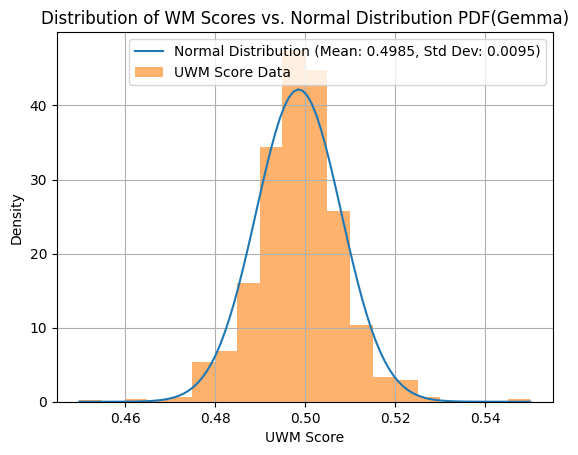

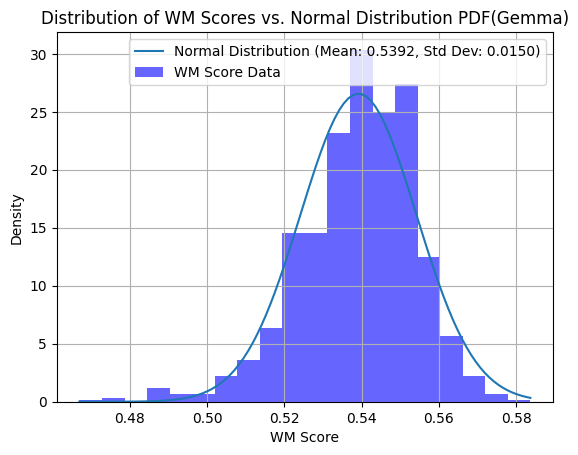

In [ ]:
#@title Plot histogram and normal distribution pdf for UWM and WM scores (Gemma)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive
from scipy.stats import norm
import statistics

drive.mount('/mnt/drive')

result = pd.read_excel('/mnt/drive/MyDrive/Output and Results.xlsx')

data = result['UWM Score']
# Access the underlying numpy array from the pandas Series
x_axis = data.values

# Calculating mean and standard deviation
mean = statistics.mean(x_axis)
sd = statistics.stdev(x_axis)

# Create a smooth range of x-values for plotting the PDF
# Use linspace to create 100 evenly spaced points between the min and max of your data
x_smooth = np.linspace(min(x_axis), max(x_axis), 100)

# Calculate the PDF values for the smooth x-values
pdf_values = norm.pdf(x_smooth, mean, sd)

# Plot the smooth PDF curve
plt.plot(x_smooth, pdf_values, label=f'Normal Distribution (Mean: {mean:.4f}, Std Dev: {sd:.4f})')

# Optionally, plot a histogram of the actual data for comparison
plt.hist(x_axis, bins=20, density=True, alpha=0.6, label='UWM Score Data')

plt.xlabel('UWM Score')
plt.ylabel('Density')
plt.title('Distribution of WM Scores vs. Normal Distribution PDF(Gemma)')
plt.legend()
plt.grid(True)
plt.show()

data = result['WM Score']
# Access the underlying numpy array from the pandas Series
x_axis = data.values

# Calculating mean and standard deviation
mean = statistics.mean(x_axis)
sd = statistics.stdev(x_axis)

# Create a smooth range of x-values for plotting the PDF
# Use linspace to create 100 evenly spaced points between the min and max of your data
x_smooth = np.linspace(min(x_axis), max(x_axis), 100)

# Calculate the PDF values for the smooth x-values
pdf_values = norm.pdf(x_smooth, mean, sd)

# Plot the smooth PDF curve
plt.plot(x_smooth, pdf_values, label=f'Normal Distribution (Mean: {mean:.4f}, Std Dev: {sd:.4f})')

# Optionally, plot a histogram of the actual data for comparison
plt.hist(x_axis, bins=20, density=True, alpha=0.6, label='WM Score Data', color = 'b')

plt.xlabel('WM Score')
plt.ylabel('Density')
plt.title('Distribution of WM Scores vs. Normal Distribution PDF(Gemma)')
plt.legend()
plt.grid(True)
plt.show()



Threshold: 0.5189775


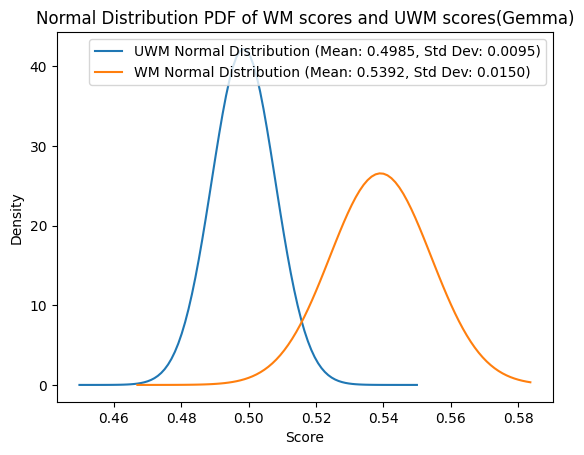

In [ ]:
#@title Plot 2 normal distribution pdf for UWM and WM (Gemma)

data = result['UWM Score']
x_axis = data.values
mean = statistics.mean(x_axis)
sd = statistics.stdev(x_axis)
x_smooth = np.linspace(min(x_axis), max(x_axis), 100)
pdf_values_uwm = norm.pdf(x_smooth, mean, sd)
plt.plot(x_smooth, pdf_values_uwm, label=f'UWM Normal Distribution (Mean: {mean:.4f}, Std Dev: {sd:.4f})')

data = result['WM Score']
x_axis = data.values
mean = statistics.mean(x_axis)
sd = statistics.stdev(x_axis)
x_smooth = np.linspace(min(x_axis), max(x_axis), 100)
pdf_values_wm = norm.pdf(x_smooth, mean, sd)

plt.plot(x_smooth, pdf_values_wm, label=f'WM Normal Distribution (Mean: {mean:.4f}, Std Dev: {sd:.4f})')
plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Normal Distribution PDF of WM scores and UWM scores(Gemma)')
plt.legend()

idx = np.argwhere(np.diff(np.sign(pdf_values_uwm - pdf_values_wm))).flatten()
print(f"Threshold: {x_axis[idx][-1]}")

Drive already mounted at /mnt/drive; to attempt to forcibly remount, call drive.mount("/mnt/drive", force_remount=True).


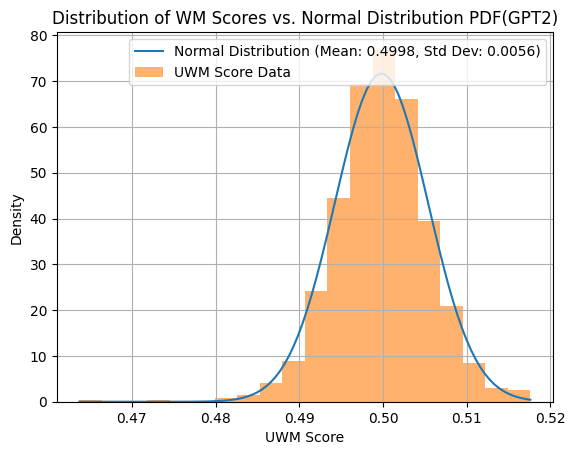

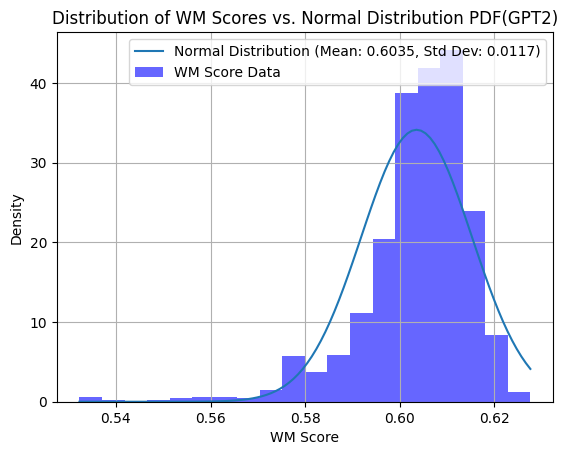

In [ ]:
#@title Plot histogram and normal distribution pdf for UWM and WM scores (GPT2)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.colab import drive
from scipy.stats import norm
import statistics

drive.mount('/mnt/drive')

result = pd.read_excel('/mnt/drive/MyDrive/Data (1).xlsx')

data = result['WMean(NWM)']
# Access the underlying numpy array from the pandas Series
x_axis = data.values

# Calculating mean and standard deviation
mean = np.nanmean(x_axis)
sd = np.nanstd(x_axis)

# Create a smooth range of x-values for plotting the PDF
# Use linspace to create 100 evenly spaced points between the min and max of your data
x_smooth = np.linspace(min(x_axis), max(x_axis), 100)

# Calculate the PDF values for the smooth x-values
pdf_values = norm.pdf(x_smooth, mean, sd)

# Plot the smooth PDF curve
plt.plot(x_smooth, pdf_values, label=f'Normal Distribution (Mean: {mean:.4f}, Std Dev: {sd:.4f})')

# Optionally, plot a histogram of the actual data for comparison
plt.hist(x_axis, bins=20, density=True, alpha=0.6, label='UWM Score Data')

plt.xlabel('UWM Score')
plt.ylabel('Density')
plt.title('Distribution of WM Scores vs. Normal Distribution PDF(GPT2)')
plt.legend()
plt.grid(True)
plt.show()

data = result['WMean(WM)']
# Access the underlying numpy array from the pandas Series
x_axis = data.values

# Calculating mean and standard deviation
mean = np.nanmean(x_axis)
sd = np.nanstd(x_axis)

# Create a smooth range of x-values for plotting the PDF
# Use linspace to create 100 evenly spaced points between the min and max of your data
x_smooth = np.linspace(min(x_axis), max(x_axis), 100)

# Calculate the PDF values for the smooth x-values
pdf_values = norm.pdf(x_smooth, mean, sd)

# Plot the smooth PDF curve
plt.plot(x_smooth, pdf_values, label=f'Normal Distribution (Mean: {mean:.4f}, Std Dev: {sd:.4f})')

# Optionally, plot a histogram of the actual data for comparison
plt.hist(x_axis, bins=20, density=True, alpha=0.6, label='WM Score Data', color = 'b')

plt.xlabel('WM Score')
plt.ylabel('Density')
plt.title('Distribution of WM Scores vs. Normal Distribution PDF(GPT2)')
plt.legend()
plt.grid(True)
plt.show()

Threshold: [0.60139513 0.60958654]


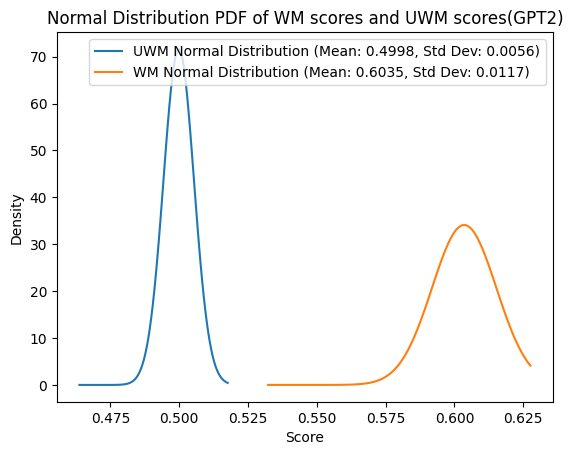

In [ ]:
#@title Plot 2 normal distribution pdf for UWM and WM (GPT2)

data = result['WMean(NWM)']
x_axis = data.values
mean = np.nanmean(x_axis)
sd = np.nanstd(x_axis)
x_smooth = np.linspace(min(x_axis), max(x_axis), 100)
pdf_values_uwm = norm.pdf(x_smooth, mean, sd)
plt.plot(x_smooth, pdf_values_uwm, label=f'UWM Normal Distribution (Mean: {mean:.4f}, Std Dev: {sd:.4f})')

data = result['WMean(WM)']
x_axis = data.values
mean = np.nanmean(x_axis)
sd = np.nanstd(x_axis)
x_smooth = np.linspace(min(x_axis), max(x_axis), 100)
pdf_values_wm = norm.pdf(x_smooth, mean, sd)

plt.plot(x_smooth, pdf_values_wm, label=f'WM Normal Distribution (Mean: {mean:.4f}, Std Dev: {sd:.4f})')
plt.xlabel('Score')
plt.ylabel('Density')
plt.title('Normal Distribution PDF of WM scores and UWM scores(GPT2)')
plt.legend()

idx = np.argwhere(np.diff(np.sign(pdf_values_uwm - pdf_values_wm))).flatten()
print(f"Threshold: {x_axis[idx]}")
#We cannot find the exact intersection for a threshold so we use 1% highest scores
#from 1000 nonwatermarked output

